# Final Project - Forest Cover Type Prediction
#### By Dream Team: Jen Darrouzet, Lance Miles, Ahsen Qamar, Jonathan Zhou

## 1.   Introduction

The following notebook summarizes the team's work product in our Final Project for w207 Applied Machine Learning for the Fall 2018 session, with instructor Yacov Salomon. The input (provided by Kaggle) is a training set of 15,000 observations of cartographic data, where each observation represents a 30 meter by 30 meter plot within one of four Wilderness Areas in Colorado. The response value of interest is the predominant tree species on the plot of land, 'Cover_Type'. Output from this notebook are the team's predictions of predominant tree species for the 560,000 plots of land that are held - unavailable to the team - by Kaggle. Our last test places our prediction accuracy within the **top 2 percentile of competing Kaggle teams**. Our report will be role played in the context of the DreamMachine contract consultancy hired by the Forest Department of Wyoming. 

### 1.1   Problem Interpretation

The DreamMachine team of Ahsen, Jen, Jon & Lance has been contracted by the Forest Department of Wyoming to help the state characterize their forest lands. Colorado - their neighboring state just to the south - recently conducted a forest land survey in 4 wilderness areas near the Wyoming border, and the Wyoming forest department is interested in determining whether a model can be built to accurately predict which forest species dominate the observations in the surveyed areas. Wyoming's ideal outcome would be to have a model built from Colorado data, which they could then adapt and use for their own wilderness areas. In this way, Wyoming may be able to cut costs on state forest survey teams (for instance, doing spot checks of their model results, instead of paying for 100% coverage) while still delivering the environmental data needed by multiple parties, including:
   * wildfire management, who frequently need to know which species exist in each locality, for tree lifespan and flammability projections,
   * land management, who may need to forecast flood/drought impact, or track infestations of pests like bark beetles - which may interact differently with various tree species,
   * environmental groups, who study different tree species as habitat used by various woodland creatures,
   * and forest resource companies (logging operations), that inquire periodically about resource extraction leases at various locales

The Wyoming Forest Department has thus tasked the DreamMachine team with using Colorado's cartographic data to develop an accurate model for making multiclass predictions of forest cover species. Specifically, every 30mx30m plot in the four Colorado wilderness areas (Cache la Poudre, Comanche Peak, Neota, and Rawah) has had it predominant tree species recorded, along with data about the individual plot's forest conditions, including:
   * elevation
   * aspect
   * slope
   * shade throughout the day
   * distances to fires, water features and roads
   * and 40 different soil types
   
The ideal model would take similar readings of elevation, soil type for an unknown plot within one of these four wilderness areas and accurately name the single predominant tree species growing there, from among the classes:

   * Spruce/Fir
   * Lodgepole Pine
   * Ponderosa Pine
   * Cottonwood/Willow
   * Aspen
   * Douglas-fir
   * Krummholz

Once the DreamMachine team can prove a reasonably accurate model can be built with the existing data, the Wyoming Forest Department will move forward contracting the team to help develop models for their own forest lands.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import math
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
try:
    from sklearn.grid_search import GridSearchCV
except ImportError:
    from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

import tensorflow as tf

from sklearn import svm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
#from sklearn import cross_validation
from sklearn.model_selection import train_test_split

# SK-learn libraries for normalizing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

from scipy import stats

# XG Boost
import xgboost as xgb

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

import plotly as py
import plotly.graph_objs as go

# suppress warning
import warnings
warnings.filterwarnings('ignore')

## 2. Data Ingestion

Our first step is to load the csv training data provided before any other tasks are completed. 

In [2]:
# List of the different cover types
categories = ['Spruce/Fir(1)', 'Lodgepole Pine(2)', 'Ponderosa Pine(3)', 'Cottonwood/Willow(4)', 
              'Aspen(5)', 'Douglas-fir(6)', 'Krummholz(7)']

# Ingest CSV training csv file
df = pd.read_csv('train.csv', delimiter=',')

## 3. Feature Engineering

Our team performed exploratory data analysis (EDA) before deriving and enriching our data with additional features. Although EDA was performed first, we've structured our document to define additional features first and then show the rationale for building these features in the EDA section below. 

In [3]:
# This variable calculates the hypotenuse of the triangular distance from water using variables 
# Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology
def hypot(data):
    return (math.sqrt(data['Horizontal_Distance_To_Hydrology']**2 + data['Vertical_Distance_To_Hydrology']**2))

# Dummy variable to capture if the water source is above or below the surveyed plot of land
def water_above(data):
    if data['Vertical_Distance_To_Hydrology'] >= 0:
        return 1
    else:
        return 0

# Captures the adjusted elevation for where water resides
def water_elev(data):
    return (data['Elevation'] - data['Vertical_Distance_To_Hydrology'])

# Aggregate the sunlight amount across our 3 data points on shade
def avg_sunlight(data):
    return float(1.0 * (data['Hillshade_9am'] + data['Hillshade_3pm'] + data['Hillshade_Noon']) / 3)

# Based on scatter plots and average values, it looks like 120 and lower is a good predictor for covertype 4. 
# The rest of the covertypes have severe overlap
def horiz_hydro_l_120(data):
    if data['Horizontal_Distance_To_Hydrology'] <= 120:
        return 1
    else:
        return 0

# Based on scatter plots and average values, it looks like 3100 may help separate cover types 1 and 2 a little 
# better. This improved predictions on some, but still have more work
def elev_greater_3100(data):
    if data['Elevation'] >= 3100:
        return 1
    else:
        return 0
    
# Fires travel faster up slopes and slower down, however we don't know whether the slope is incline or decline 
# from fire point. Elevation will be factored in as a rough estimate of incline vs decline
def fire_incline(data):
    weight = 500
    elev_data = StandardScaler().fit_transform(data['Elevation'].values.reshape(-1, 1))
    return (-1.0 * elev_data[:,0] * data['Slope'].values * weight) + data['Horizontal_Distance_To_Fire_Points'].values

# Zero-slope with water could be swampy. Rocky & steep sees water disappear downhill, so only very nearby trees 
# benefit. Water access is a function of distance, slope and how absorbant the soil is.
# This measure is dependent on soil_bin and hyp_water derived features
def weighted_water_access(data):
    weight = 1000
    return (-1.0 * data['Slope'] * weight + data['Horizontal_Distance_To_Fire_Points'])

# Deltas between horizontal water and fire point distances
def fire_water_neg(data):
    return data['Horizontal_Distance_To_Hydrology'] - data['Horizontal_Distance_To_Fire_Points']

# Sum of water and fire point distances
def fire_water_pos(data):
    return data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Fire_Points']

# Deltas between horizontal roadways and fire point distances
def fire_road_neg(data):
    return data['Horizontal_Distance_To_Roadways'] - data['Horizontal_Distance_To_Fire_Points']

# Sum of roadways and fire point distances
def fire_road_pos(data):
    return data['Horizontal_Distance_To_Roadways'] + data['Horizontal_Distance_To_Fire_Points']

# Deltas between horizontal roadways and water distances
def water_road_neg(data):
    return data['Horizontal_Distance_To_Roadways'] - data['Horizontal_Distance_To_Hydrology']

# Sum of roadways and water distances
def water_road_pos(data):
    return data['Horizontal_Distance_To_Roadways'] + data['Horizontal_Distance_To_Hydrology']

# Return value of 1 means west-facing & return value of 0 means east-facing
def westiness_using_neg_sin_aspect(data):
    return (-1 * np.sin((data['Aspect']).astype(float) * np.pi / 180.0) + 1.0)/2.0

# Return value of 1 means south-facing & return value of 0 means north-facing
def southiness_using_neg_cos_aspect(data):
    return (-1 * np.cos((data['Aspect']).astype(float) * np.pi / 180.0) + 1.0)/2.0

# High values are steep, west-facing slopes where sun's radiation evaporates soil moisture
def interact_west_slope(data):
    return ((-1 * np.sin((data['Aspect']).astype(float) * np.pi / 180.0) + 1.0)/2.0) * data['Slope']

# High values are high-altitude west facing plots
def interact_west_elev(data):
    return (-1 * np.sin((data['Aspect']).astype(float) * np.pi / 180.0) + 1.0)/2.0 * data['Elevation']

# Given any elevation, the south slope gets most sun and most protection from north's cold winds
def interact_south_slope(data):
    return ((-1 * np.cos((data['Aspect']).astype(float) * np.pi / 180.0) + 1)/2.0) * data['Slope']

# High values are high-altitude south facing plots
def interact_south_elev(data):
    return (-1 * np.cos((data['Aspect']).astype(float) * np.pi / 180.0) + 1)/2.0 * data['Elevation']

# High values are high altitude, steep, north-facing slopes; think TheNorthFace.com type cold
def interact_north_elev_slope(data):
    return ((np.cos((data['Aspect']).astype(float) * np.pi / 180.))+1)/2.0 * data['Elevation'] * data['Slope']

# Calculate shade at 10am from 9am and noon data
def hillshade_10am(row):
    hillshade_delta = row['Hillshade_Noon'] - row['Hillshade_9am']
    return row['Hillshade_9am'] + hillshade_delta/3

# Calculate shade at 11am from 9am and noon data
def hillshade_11am(row):
    hillshade_delta = row['Hillshade_Noon'] - row['Hillshade_9am']
    return row['Hillshade_9am'] + hillshade_delta/2

# Calculate shade at 1pm from 3pm and noon data
def hillshade_1pm(row):
    hillshade_delta = row['Hillshade_3pm'] - row['Hillshade_Noon']
    return row['Hillshade_Noon'] + hillshade_delta/3

# Calculate shade at 2pm from 3pm and noon data
def hillshade_2pm(row):
    hillshade_delta = row['Hillshade_3pm'] - row['Hillshade_Noon']
    return row['Hillshade_Noon'] + hillshade_delta/2

# Merge elevation and aspect features
def ele_asp(row):
    return row['Elevation']*row['Aspect']

# Merge elevation and fire point distance
def fire_ele(row):
    return row['Elevation']*row['Horizontal_Distance_To_Fire_Points']

# Binarize horizontal fire point distance to far or close
def bin_fire_dist(row):
    if row['Horizontal_Distance_To_Fire_Points'] < 1256:
        return 1
    else:
        return 0
    
def squared_fire_road(data):
    return (data['Horizontal_Distance_To_Fire_Points']**2)

def fire_water_neg_squar(data):
    return ((data['Horizontal_Distance_To_Hydrology'] - data['Horizontal_Distance_To_Fire_Points'])**2)

# For all of the new feature functions defined, we will calculate these features for our training data
west_facing_aspect = df.apply(westiness_using_neg_sin_aspect, axis=1)
south_facing_aspect = df.apply(southiness_using_neg_cos_aspect, axis=1)
slope_by_west = df.apply(interact_west_slope, axis=1)
elev_by_west = df.apply(interact_west_elev, axis=1)
slope_by_south = df.apply(interact_south_slope, axis=1)
elev_by_south = df.apply(interact_south_elev, axis=1)
high_steep_north_face = df.apply(interact_north_elev_slope, axis=1)
hyp_water = df.apply(hypot, axis=1)
hydro_elev = df.apply(water_elev, axis=1)
tot_sunlight = df.apply(avg_sunlight, axis=1)
hydro_above = df.apply(water_above, axis=1)
hydro_Hori_L_120 = df.apply(horiz_hydro_l_120, axis=1)
Elevation_G_3100 = df.apply(elev_greater_3100, axis=1)
fire_dist_adjust = fire_incline(df)
water_access = weighted_water_access(df)
fire_water_sub = df.apply(fire_water_neg, axis=1)
fire_water_add = df.apply(fire_water_pos, axis=1)
fire_road_sub = df.apply(fire_road_neg, axis=1)
fire_road_add = df.apply(fire_road_pos, axis=1)
water_road_sub = df.apply(water_road_neg, axis=1)
water_road_add = df.apply(water_road_pos, axis=1)
squared_fire_road_dist = df.apply(squared_fire_road, axis=1)
fire_water_sub_s = df.apply(fire_water_neg_squar, axis=1)

# For all of the newly generated features, add them into the dataframe
df.insert(loc = 11, column = 'hyp_water', value = hyp_water)
df.insert(loc = 12, column = 'squared_fire_dist', value = squared_fire_road_dist)
df.insert(loc = 13, column = 'hydro_elev', value = hydro_elev)
df.insert(loc = 14, column = 'South=1&North=0', value = south_facing_aspect.astype(int))
df.insert(loc = 15, column = 'West=1&East=0', value = west_facing_aspect.astype(int))
df.insert(loc = 16, column = 'elev_x_west', value = elev_by_west.astype(int))
df.insert(loc = 17, column = 'fire_water_sub', value = fire_water_sub)
df.insert(loc = 18, column = 'fire_road_sub', value = fire_road_sub)
df.insert(loc = 19, column = 'water_road_sub', value = water_road_sub)
df.insert(loc = 20, column = 'fire_road_add', value = fire_road_add)
df.insert(loc = 21, column = 'fire_water_add', value = fire_water_add)
df.insert(loc = 22, column = 'water_road_add', value = water_road_add)
df.insert(loc = 23, column = 'fire_water_sub_squared', value = fire_water_sub_s)

df.insert(loc = 24, column = 'avg_sunlight', value = tot_sunlight)
df.insert(loc = 25, column = 'hydro_above', value = hydro_above)
df.insert(loc = 26, column = 'hydro_Hori_L_120', value = hydro_Hori_L_120)
df.insert(loc = 27, column = 'Elevation_G_3100', value = Elevation_G_3100)
df.insert(loc = 28, column = 'fire_dist_adjust', value = fire_dist_adjust.astype(int))
df.insert(loc = 29, column = 'water_access', value = water_access.astype(int))
df.insert(loc = 30, column = 'slope_x_west', value = slope_by_west.astype(int))
df.insert(loc = 31, column = 'slope_x_south', value = slope_by_south.astype(int))
df.insert(loc = 32, column = 'elev_x_south', value = elev_by_south.astype(int))
df.insert(loc = 33, column = 'north_x_elev_x_slope', value = high_steep_north_face.astype(int))
df.insert(len(df.columns)-1, 'Hillshade_10am', df.apply(lambda row: hillshade_10am(row),axis=1))
df.insert(len(df.columns)-1, 'Hillshade_11am', df.apply(lambda row: hillshade_11am(row),axis=1))
df.insert(len(df.columns)-1, 'Hillshade_1pm', df.apply(lambda row: hillshade_1pm(row),axis=1))
df.insert(len(df.columns)-1, 'Hillshade_2pm', df.apply(lambda row: hillshade_2pm(row),axis=1))
df.insert(len(df.columns)-1, 'Elevation_Fire', df.apply(lambda row: fire_ele(row),axis=1))
df.insert(len(df.columns)-1, 'To_Fire_Or_Not_To_Fire', df.apply(lambda row: bin_fire_dist(row),axis=1))

category_index = 33

## 4. Exploratory Data Analysis

In preparation for the modeling phase, we begin with some exploratory data analysis. It is important to note that this project has been an iterative process. After conducting initial exploratory data analysis, feature engineering, modeling, and revisiting each of these stages, we have identified the core features that are helping drive our predictions. For this reason, we have minimized our EDA to this list of cores features. Although we have thoroughly looked at many of the relationships among the features in the dataset -- both raw and engineered -- we are only presenting exploratory analysis for the key features included in the final models.

### 4.1 Boxplots by Cover Type

We begin our exploratory analysis by looking at boxplots of key features. As seen in the data, it appears that elevation is single handedly the most important delineator of cover types. Although there is a great deal of overlap among cover types, many of the other features help tease out different relationships among cover types. For instance, it appears that horizontal distance to roadways helps differentiate cover types spruce/fir (1), lodgepole pine (2),  and krummholz (7) from ponderosa pine (3), cottonwood/willow (4), aspen (5), and douglas-fir (6). It is important to note that this could be an artifact of elevation in that roads are not built high up in the mountains. If this is the case, we may be introducing some level of collinearity between horizontal distance to roadways and elevation, but it appears (from the modeling phase) that this is an important feature to include in the final dataset. A possible explanation for this could be due to the mechanism in which some of these cover types propagate. For instance, cover types such as lodgepole pines require fire or intense heat as a mechanism for reproduction. Being far from the road means that it will be more difficult to put out forest fires in those regions. For this reason, it may be that distance to road is an important feature for allowing certain species of cover types to thrive. We also observed that horizontal distance to hydrology played a key role in predicting cottonwood/willow (4). It is no surprise that some species of trees are highly sensitive to water availability, which is why we have included many key hydrology metrics in our final dataset. Although all plants require sunlight in order to thrive, certain species require more than others, which is why hillshade metrics may be important features in delineating various cover types.

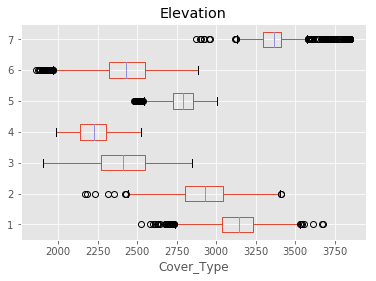

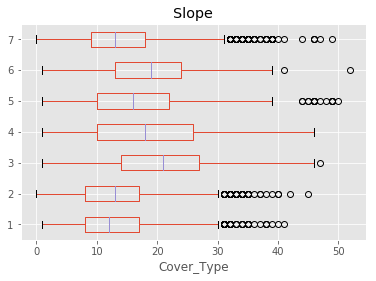

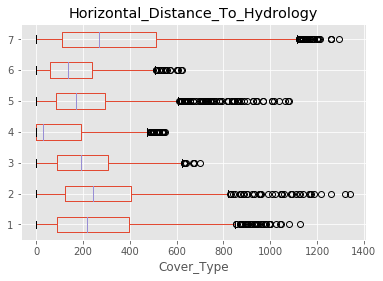

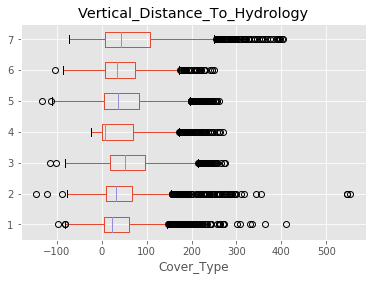

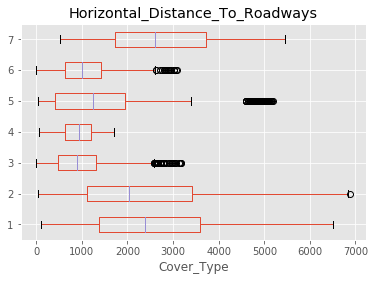

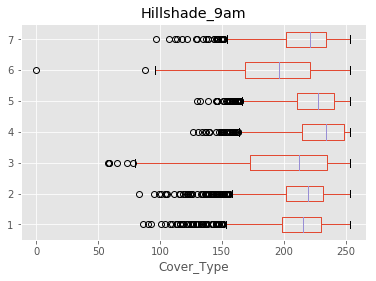

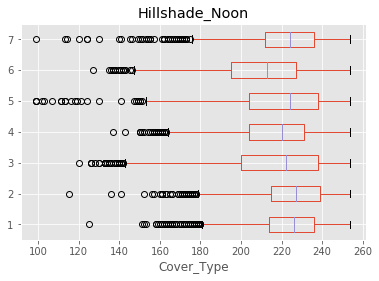

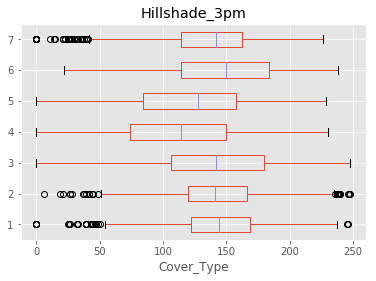

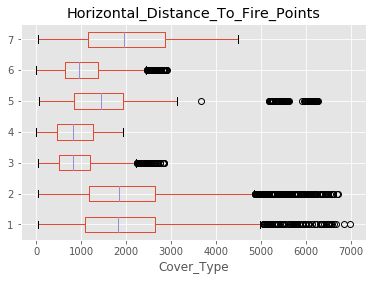

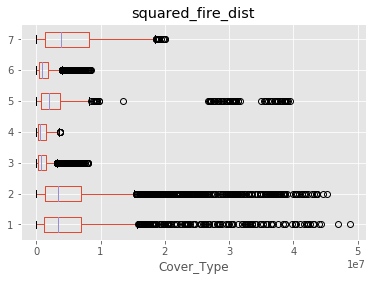

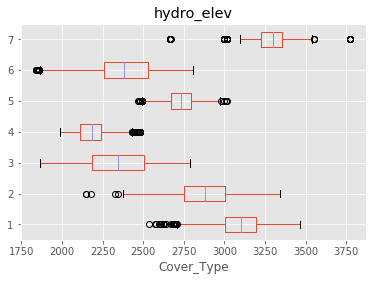

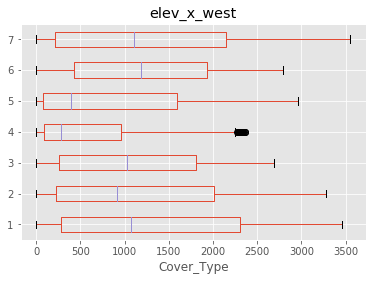

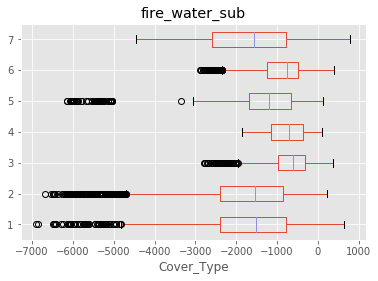

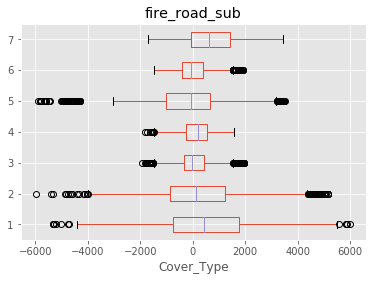

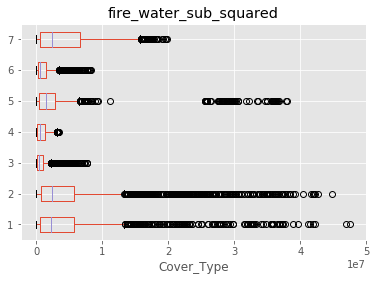

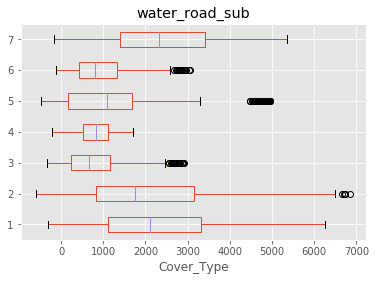

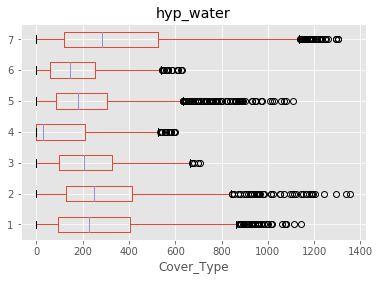

In [4]:
to_box = ['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
         'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
         'Horizontal_Distance_To_Fire_Points', 'squared_fire_dist', 'hydro_elev', 
         'elev_x_west', 'fire_water_sub', 'fire_road_sub', 'fire_water_sub_squared',
         'water_road_sub',  'hyp_water']

for i in list(to_box):
    axes = df.boxplot(vert=False,column=[i],by="Cover_Type")
    fig = axes.get_figure().suptitle('')

### 4.2 Correlation Analysis

In preparation for the modeling phase, we looked at correlations to see if there are any strong relationships among variables. It is important to note that many of the strong relationships observed in the chart, below, are due to collinearity. Although this was a concern, we found that the inclusion of these features improved the accuracy of our models on dev and test data. 

Of note, elev_x_west was highly correlated with hillshade_3PM and hillshade_9am. This implies that higher west facing slopes had greater exposure to sun. It is possible that the combination of these features will be strong predictors for certain cover types. We also find that slope is highly correlated with hillshade_noon. As mentioned previously, elevation has a strong correlation with horizontal distance to roadways. Some of the strongest correlations have been summarized, below.



|Variable 1                          |Variable 2                            |Corr.   |
|------------------------------------|--------------------------------------|--------|
|Hillshade_3pm                       |elev_x_west                           |0.823283|
|Hillshade_9am                       |Hillshade_3pm                         |0.779965|
|Hillshade_9am                       |elev_x_west                           |0.737247|
|Horizontal_Distance_To_Hydrology    |Vertical_Distance_To_Hydrology        |0.652142|
|Hillshade_Noon                      |Hillshade_3pm                         |0.614526|
|Slope                               |Hillshade_Noon                        |0.612613|
|Horizontal_Distance_To_Roadways     |Elevation / hydro_elev                |+0.57866|
|Horizontal_Distance_To_Roadways     |Horizontal_Distance_To_Fire_Points    |0.486386|
|Horizontal_Distance_To_Fire_Points  |water_road_sub                        |0.470560|
|Hillshade_Noon                      |elev_x_west                           |0.428884|
|Elevation                           |Horizontal_Distance_To_Hydrology      |0.412712|

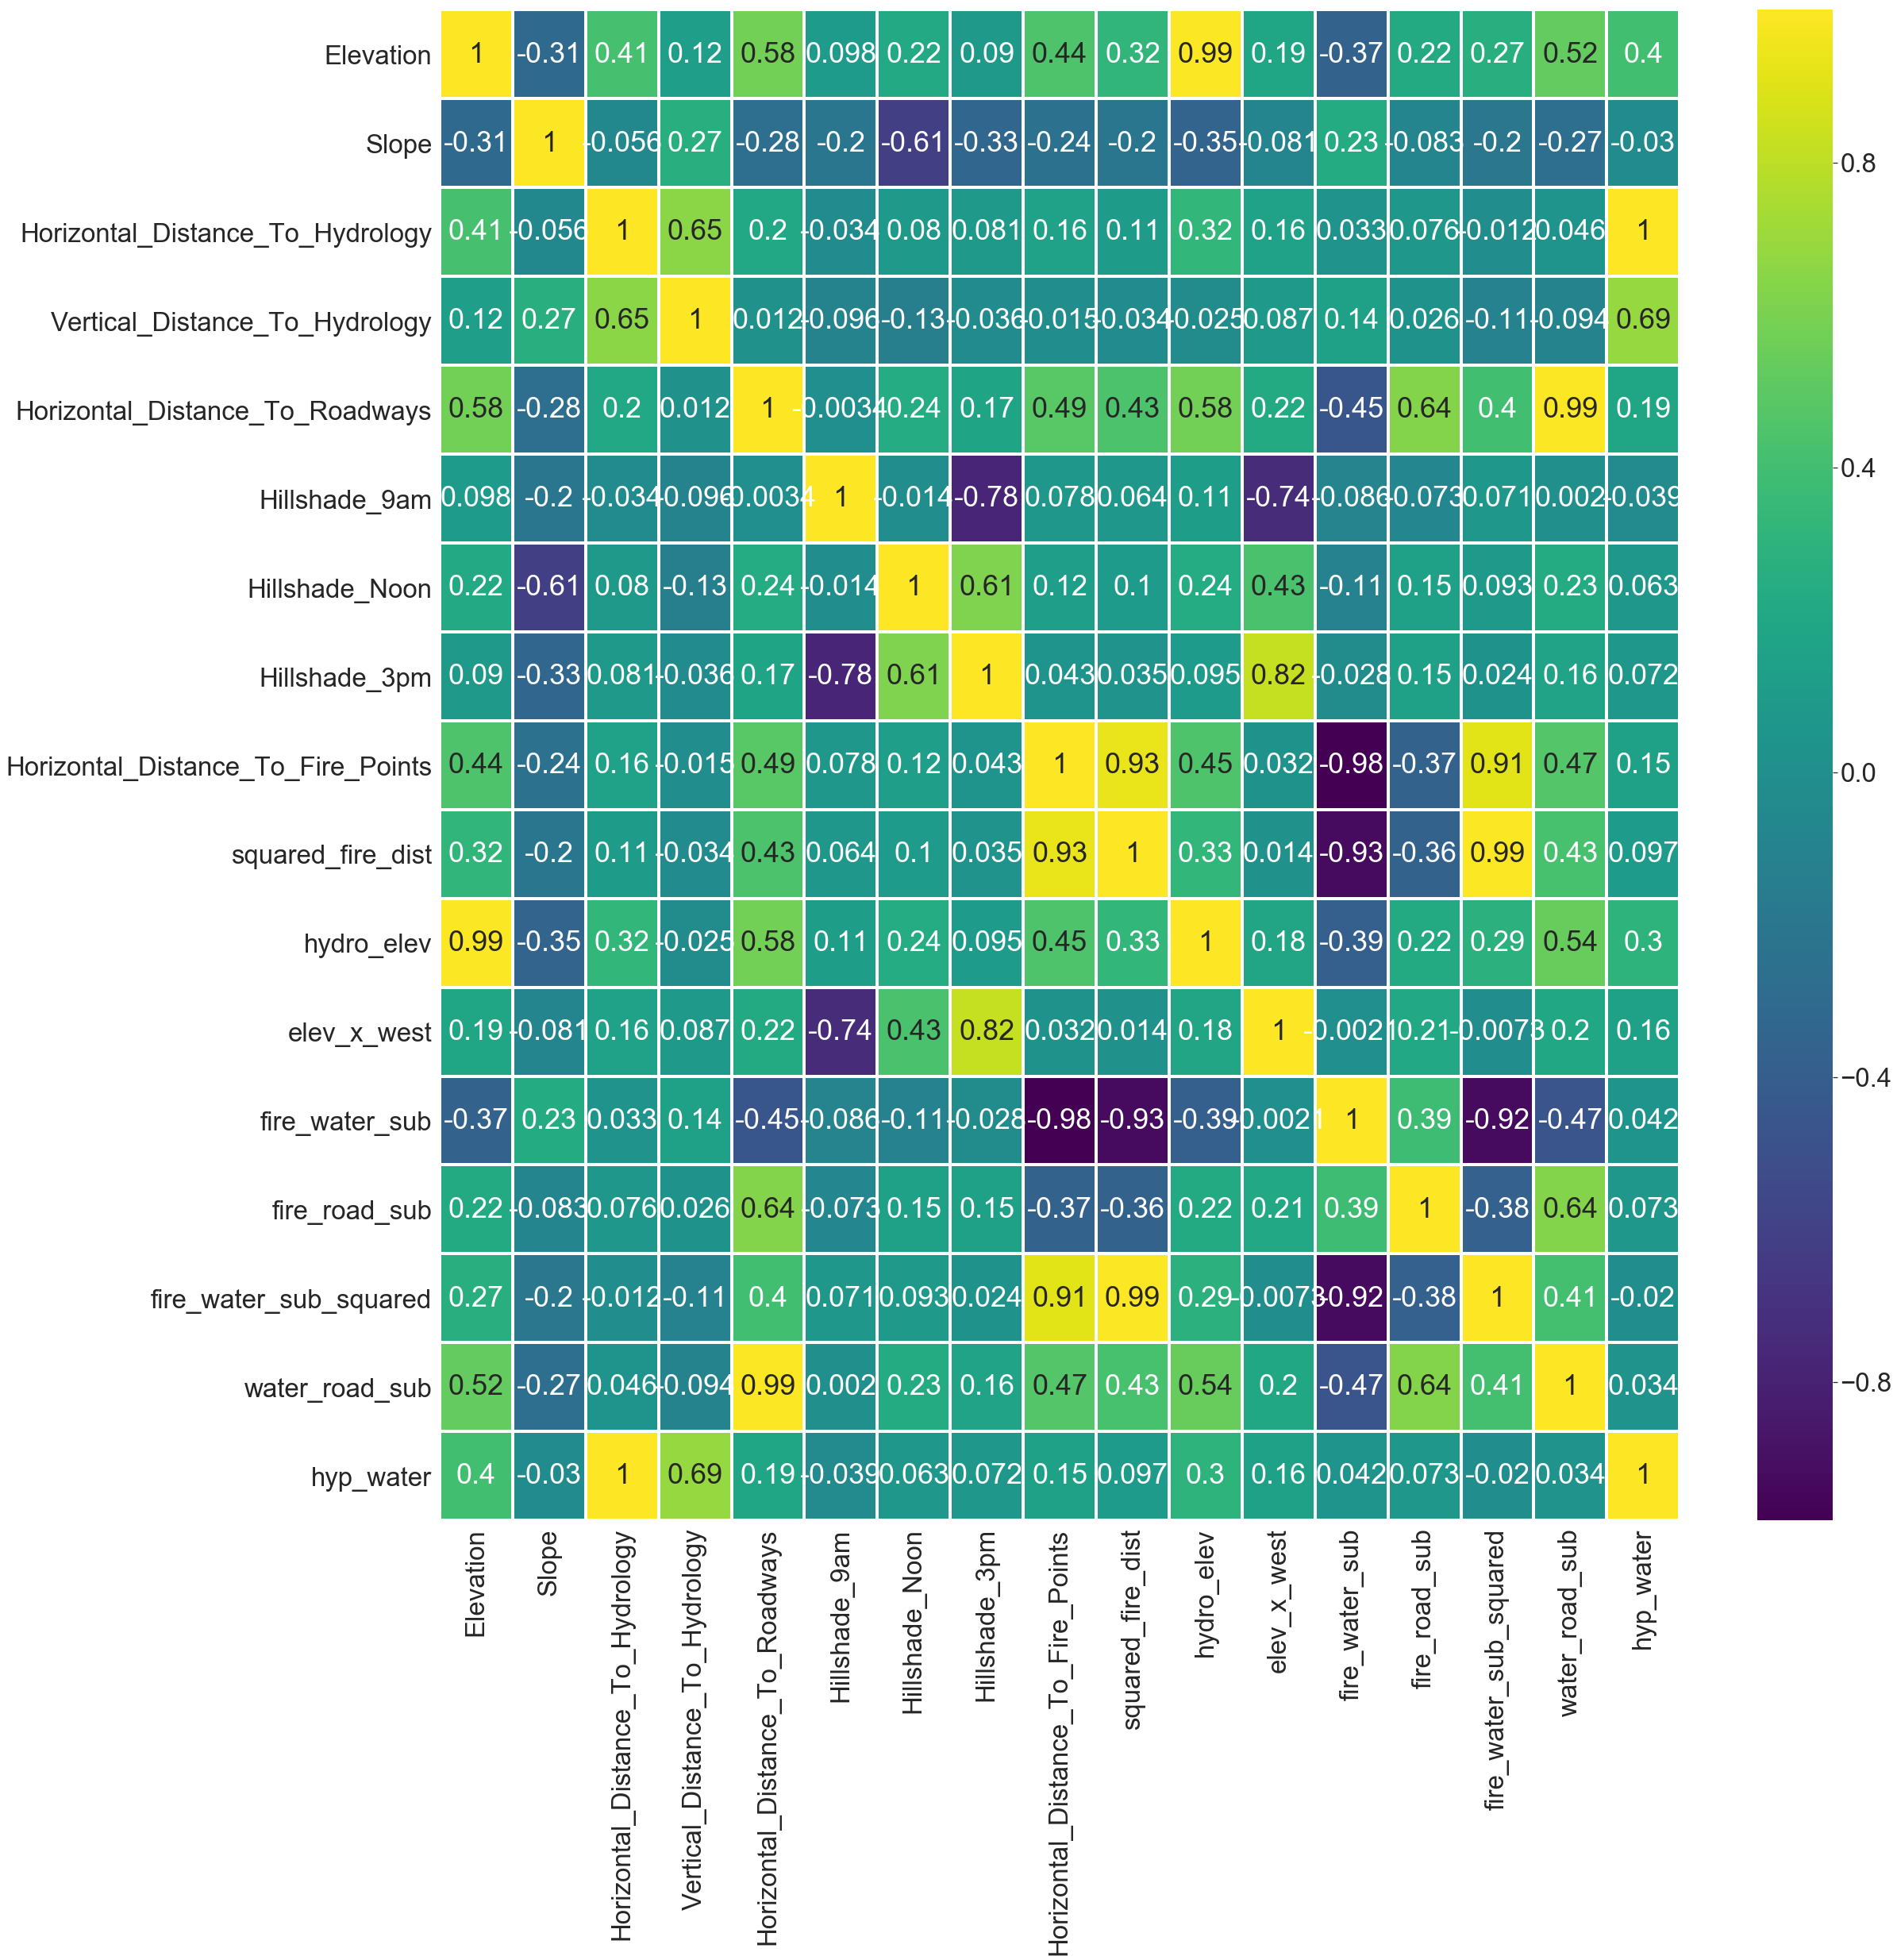

In [5]:
# Correlation Matrix of Continuous Variables
fig = plt.figure()
fig.set_size_inches(35, 35)
sns.set(font_scale=3)

corrmat = df.loc[:,to_box].corr()

sns.heatmap(corrmat, cmap='viridis', annot=True, linewidths=3)

In [6]:
#Code taken from the following resource https://stackoverflow.com/a/41453817
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df.loc[:,to_box], 30))

Top Absolute Correlations
Horizontal_Distance_To_Hydrology    hyp_water                             0.998490
Elevation                           hydro_elev                            0.989200
squared_fire_dist                   fire_water_sub_squared                0.989189
Horizontal_Distance_To_Roadways     water_road_sub                        0.987379
Horizontal_Distance_To_Fire_Points  fire_water_sub                        0.981612
                                    squared_fire_dist                     0.934388
squared_fire_dist                   fire_water_sub                        0.925559
fire_water_sub                      fire_water_sub_squared                0.921489
Horizontal_Distance_To_Fire_Points  fire_water_sub_squared                0.907991
Hillshade_3pm                       elev_x_west                           0.823283
Hillshade_9am                       Hillshade_3pm                         0.779965
                                    elev_x_west              

### 4.3 Scatter Plot Matrix

In preparation for the modeling phase, we would like to investigate scatter plot matrices to look at the distribution of key variables. It is important to note that we have selected key scatter plots to present as the total number of features included in the modeling phase was over 60 features. For this reason, we have focused in on key relationships that show some level of delineation among cover types.

As previously discussed, elevation seems to provide the best separation between cover types. Of note, the scatter plot of elevation and squared distance to fire points (squared_fire_dist) reveals a nice series of clustered cover types. In the modeling phase, we observed that cover types 1 and 2 (spruce/fir and lodgepole pine) and 3 and 6 (ponderosa pine and douglas-fir) were among the most misclassified pairs. It appears that introducing the quadratic horizontal distance to fire points has helped these cases.

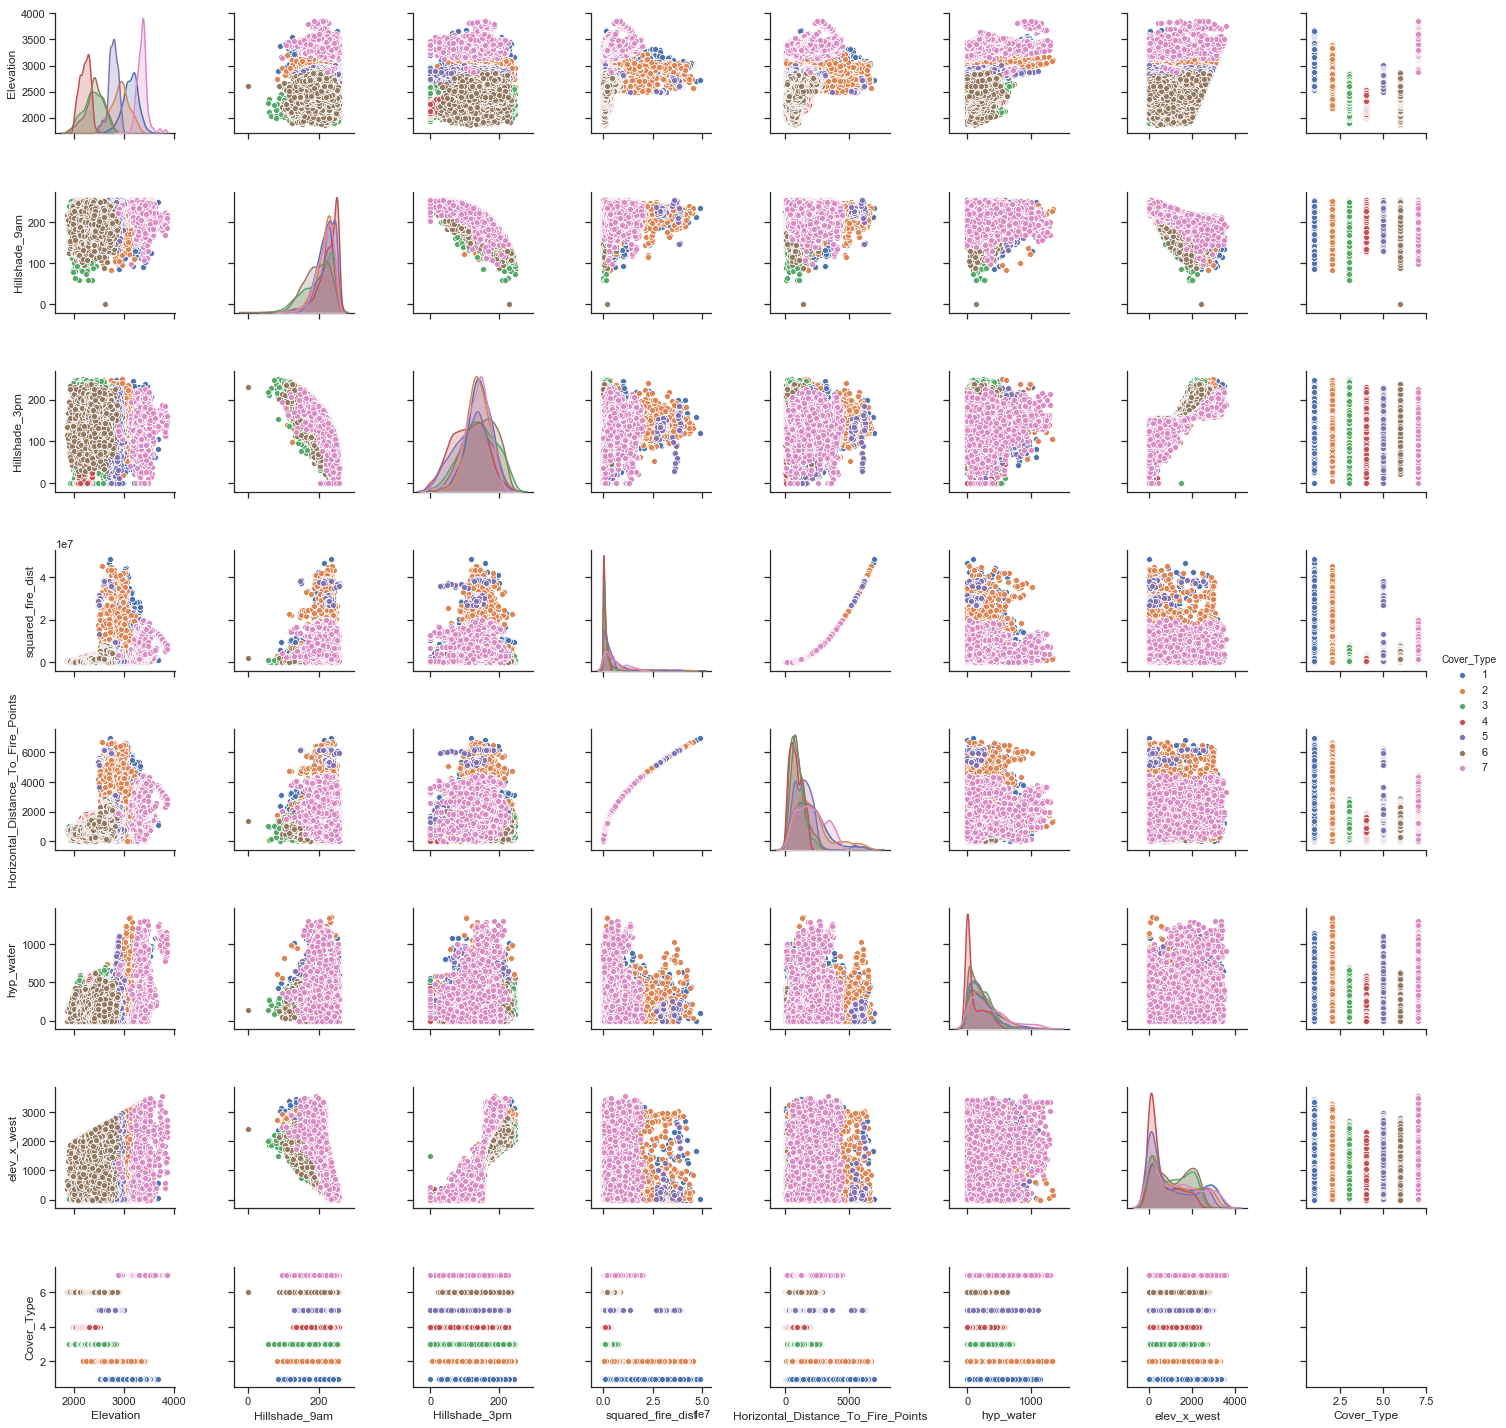

In [7]:
cols = ['Elevation',
        'Hillshade_9am',
        'Hillshade_3pm',
        'squared_fire_dist',
        'Horizontal_Distance_To_Fire_Points',
        'hyp_water',
        'elev_x_west',
        'Cover_Type']

sns.set(style="ticks")
sns.pairplot(df[cols], hue='Cover_Type')

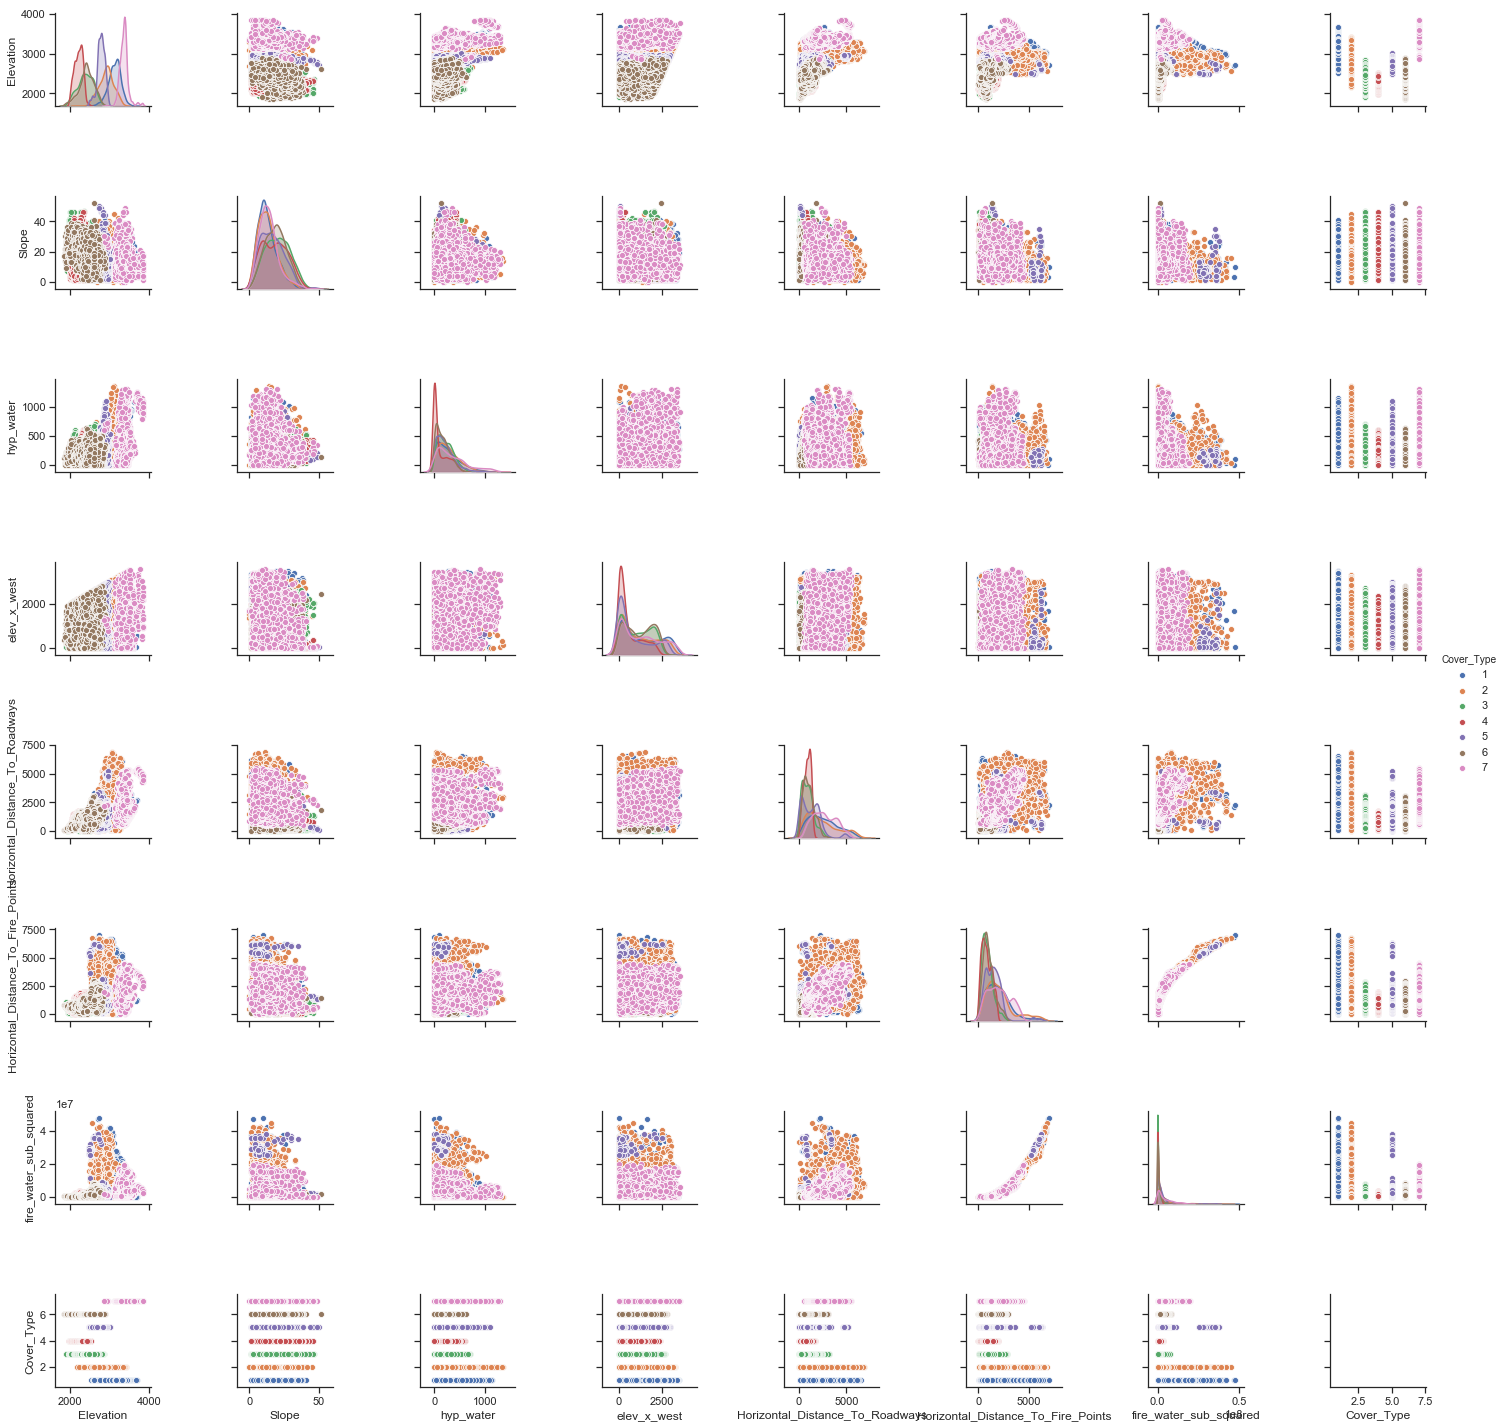

In [8]:
cols = ['Elevation',
        'Slope',
        'hyp_water',
        'elev_x_west',
        'Horizontal_Distance_To_Roadways',
        'Horizontal_Distance_To_Fire_Points',
        'fire_water_sub_squared', 
        'Cover_Type']

sns.set(style="ticks")
sns.pairplot(df[cols], hue='Cover_Type')

### 4.4 Interactive 3D Exploratory Data Analysis

Looking at the relationship between slope, elevation, and aspect, we see a pretty clear separation between covertypes. Our models have been struggling to differentiate between covertypes 1 and 2 (spruce/fir and lodgepole pines) as well as cover types 3 and 6 (ponderosa pine and douglas-fir). As we can see from the 3d plot, below, although there are clear separations in cover types, there is also a vast amount of overlap between points. Teasing out these relationships will be difficult, but we are up for the challenge.

**Please note that the graph is interactive and can be filtered by cover types**

In [9]:
py.offline.init_notebook_mode(connected = True)

data = []
clusters = []
colorway = ['#f3cec9', '#e7a4b6', '#cd7eaf', '#a262a9', '#6f4d96', '#3d3b72', '#182844']

for i in range(len(np.unique(df['Cover_Type'].values))):
    name = categories[i]
    color = colorway[i]
    X = df[df['Cover_Type'] == (i + 1)]['Slope']
    Y = df[df['Cover_Type'] == (i + 1)]['Elevation']
    Z = df[df['Cover_Type'] == (i + 1)]['Aspect']
    
    trace = dict(
        name = name,
        x = X, y = Y, z = Z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, color=color, line=dict(width=0) ) )
    data.append( trace )

layout = dict(
    width=800,
    height=550,
    autosize=False,
    title='Slope by Elevation by Aspect',
    scene=dict(
        xaxis=dict(
            title = 'Slope',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title = 'Elevation',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title = 'Aspect',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data, layout=layout)

py.offline.iplot(fig, filename='simple-3d-scatter')

## 5. Feature Selection

Looking at the initial EDA what immediately stands out is that soil types 7 and 15 are all zeros in our training data. Our initial intuition lead us to believe that the removal of soil types 7 and 15 would improve our model accuracies, but we found that these features help improve accuracy of both dev and test data. This is likely due to the fact that the test data is significantly larger than train data. Hence, it makes sense to leave these in for now as we believe that it will have an impact in the test data.

As mentioned previously, data exploration, feature selection and engineering, as well as modeling and classification have been an iterative process. After culling the extraneous features and identifying key relationships within the data, we have narrowed down our set of features to the following:

* **Elevation**
    * Elevation is the strongest separator of classes found in the data.
* **hydro_elev**
    * Although Elevation is already included, hydro_elevation helps improve the delineation between covertypes 1, 2, 3, and 6. 
* **Slope**
    * It is likely that slope helps knit together sun exposure variables as well as water related variables
* **Horizontal and Vertical Distance to Hydrology**
    * Helps identify water sensitive cover types
* **hyp_water**
    * Although we are including horizontal and vertical distances to hydrology, calculating the hypotenuse improved model accuracies across the board.
* **Horizontal_Distance_To_Roadways**
    * Improves separation of cover types.  
* **Hillshade Metrics**
    * Provides important data on sun exposure throughout the day
* **Horizontal_Distance_To_Fire_Points**
    * Helps identify regions that are more prone to fire points
* **squared_fire_dist**
    * Including the quadratic term helped misclassifications between cover types 1 and 2
* **South=1&North=0**
    * Models have a hard time discerning between 0 and 359 (even though they are effectively synonymous) so we have transformed aspect into a variable that helps add directionality.
* **West=1&East=0**
    * Models have a hard time discerning between 0 and 359 (even though they are effectively synonymous) so we have transformed aspect into a variable that helps add directionality.
* **elev_x_west**
    * Elevation by direction helps provide further insight into key information within other features. It helps stitch together the relationship between elevation, west, and exposure to sun, etc. To our surprise, elev_x_south lead to more misclassifications. 
* **Addition and Subtraction of Horizontal Distance to Fire Point and Water**
    * The horizontal distances do not provide any sense of directionality. For this reason we have included both the subtraction and addition of these horizontal distances to fire point and water to provide a sense of the possible range of horizontal distances to these points.
* **fire_water_sub_squared**
    * Based on EDA of the misclassified instances among tree based classifiers, we observed that cover types 1 and 2 (spruce/fir and lodgepole pine) and 3 and 6 (ponderosa pine and douglas-fir) may be further separable if we squared the engineered feature horizontal distance to fire point minus horizontal distance to hydrology.
* **Addition and Subtraction of Horizontal Distance to Fire Point and Road**
    * The horizontal distances do not provide any sense of directionality. For this reason we have included both the subtraction and addition of these horizontal distances to fire points and road to provide a sense of the possible range of horizontal distances to these points. 
* **Addition and Subtraction of Horizontal Distance to Water and Road**
    * The horizontal distances do not provide any sense of directionality. For this reason we have included both the subtraction and addition of these horizontal distances to water and road to provide a sense of the possible range of horizontal distances to these points. 
* **Wilderness Areas**
    * Certain cover types favor specific wilderness areas. Inclusion of these variables has improved accuracy and has likely provided insights into features (outside of the scope of these data) that help differentiate cover types.
* **Soil Types**
    * Certain cover types prefer specific soil types. The inclusion of these features has drastically improved accuracy.

## 6. Data Splitting

As it is difficult to test our models against the test data on kaggle and get the results, we've split our existing training data into a training and dev data set. We've included a lot of control in our data splitting function so that the training data set can include different proportions of each tree cover type. 

By adjusting the different proportions of cover types in our training set, we can influence the models generated. 

From optimization by testing with various combinations of additional features with our models, the additional features were identified as having either an overall positive / negative impact. As part of that, we filtered out the unhelpful features below as well, while keeping all of the original features as well. 

Standard Scaler transformations were also performed on non-binary features for training and dev data to be used in certain models as well. 

In [10]:
feats = ['Id', 'Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
         'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
         'Horizontal_Distance_To_Fire_Points', 'hyp_water','squared_fire_dist', 'hydro_elev', 
          'elev_x_west', 'fire_water_sub', 'fire_water_add', 'fire_road_sub', 'fire_road_add', 'water_road_sub',
          'water_road_add',  'fire_water_sub_squared', 'South=1&North=0', 'West=1&East=0', 'Wilderness_Area1', 'Wilderness_Area2', 
         'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 
         'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 
         'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
         'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25',
         'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
         'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 
         'Soil_Type40', 'Cover_Type']

selected_data = df.loc[:,feats]

In [11]:
# Split dataframe into train and dev datasets and labels by specific amounts for each tree type
np.random.seed(0)

def data_split(selected_data, features, split_amount):
   # Generate splits for each tree type
    for i in xrange(1,8):
        data = selected_data.loc[selected_data['Cover_Type'] == i].values
        trn, dev = train_test_split(data, test_size=split_amount[i-1])

        if (i == 1):
            train_data = trn
            dev_data = dev
        else:
            train_data = np.append(train_data, trn, axis=0)
            dev_data = np.append(dev_data, dev, axis=0)

    return train_data[:,0:(features-1)], dev_data[:,0:(features-1)], train_data[:,(features-1)], dev_data[:,(features-1)]


length, features = selected_data.shape
train_data, dev_data, train_labels, dev_labels = data_split(selected_data, features, [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

# Remove the Id column from training data
dev_IDs = map(int,dev_data[:,0])
train_IDs = map(int,train_data[:,0])
train_data = np.delete(train_data, 0, axis=1)
dev_data = np.delete(dev_data, 0, axis=1)

print train_data.shape, train_labels.shape, dev_data.shape, dev_labels.shape

# Transform measure features with StandardScalar
def measure_transform (data, transform): 
    measures = transform().fit_transform(data[:,0:category_index])
    
    # Concat transformed measures category features
    return np.concatenate((measures,data[:,category_index:]),axis=1)

(12096, 66) (12096,) (3024, 66) (3024,)


In [12]:
category = 21

scaled_train_data = measure_transform(train_data, StandardScaler)
scaled_dev_data = measure_transform(dev_data, StandardScaler)

## 7. Modeling

Starting off we aimed to cast a wide net across different models and see how they behave. The models we ran for baselines were:
* Multinomial Naive Bayes (MNB)
  * Given the real-valued nature of the data, maybe being a little naive will help
  * MNB is a primarily used for document classification using text analysis. The similarity lies in the classification aspect but the difference lies in the data format. We are curious to see how MNB will handle cartographic data!
* Logistic Regression (LR)
  * If we didn't at least try this we would be shunned by the Statistics community...
  * The basic functionality for predicting a category is supplied by this model. However, LR depends highly on a sufficient amount of data. LR will perform well given our train size is sufficient.
* k Nearest Neighbors (kNN)
  * This one is for Ned Flanders!
  * If the labels have enough separation between them with little overlap, we expect the kNN to perform will. This will also confirm or deny whether any clustering exists in the feature space.
* Neural Nets (NN)
  * If we can think it, we can do it!
  * Neural nets are expected to perform well for classification prediction problems. The challenging approach to this model is understanding and fine tuning parameters.
* Decision Trees (DT)
  * [TreeBeard](http://lotr.wikia.com/wiki/Treebeard) demanded these be included!
  * Given that the feature space has good decision boundaries, DTs should perform well.
* Gradient Boosting Classifier (GBC)
  * I got nothing for this one. It's like Legolas in the Hobbit movies. 
  * The idea was to see if an additive model with a loss function would work well to predict the cover type. The underlying model is using decision trees so maybe this is that extra fertilizer.
* Deep Learning (DL)
  * I mean, why not??
  * The primary purpose for this model was experimentation to see how an unsupervised model would evaluate the feature space.
* Support Vector Machines (SVM)
  * This is the role no one wants in any video game ):
  * The purpose of SVMs is to find complex decision boundaries. If SVM cannot find these, then the feature space as is may not be good enough. This will point us to focus on feature engineering.

* Gaussian Mixture Models (GMM)
  * Think yellow M&Ms mixed with yellow skittles.
  * The idea for GMMs is that if the cover types have any clustering within the feature space, we will see it here. If we don't, the next challenge is to determine whether there is feature that can be engineered resulting in clustering.

#### Results
In the context of each model in isolation relative to performance on our dev data set, we observed that Decision Trees (boosted and extra), GBC, and deep learning perform the best.

#### Ensemble
Our ensemble consists of:
  * XGBoost
  * ADABoost
  * ExtraTrees
  * Random Forests
  * kNN
  * Deep Learning
  * SVM
  * GMM
  
Overall we are satisfied with the models making up our ensemble. They were the best baseline performers. However, it is important to call out that most of these models are decision tree based. The challenge will be seeing which models pair best with other models.

#### Misclassification Data Exploration

We have created a small function to further investigate the misclassified instances in each of our models.

In [13]:
def misclass_drilldown(pred = dev_labels):
    wrong_check = np.where(pred != dev_labels)[0]
    w_labels, test_out = dev_labels[wrong_check], pred[wrong_check]
    wrong_IDs = [dev_IDs[i] for i in wrong_check]
    data_check = df.loc[df['Id'].isin(wrong_IDs)]

    return data_check, w_labels, test_out

#### Feature Importance

This function will be used to print the most important features that are driving some of our strongest classifiers.

In [14]:
def feat_import(features, n = 20):
    index = features.argsort()[-n:][::-1]
    
    print "Top {} Important Features\n".format(n)
    
    for f in range(n): 
        print("%d. %s (%f)" % (f + 1, selected_data.columns[index[f]+1], features[index[f]]))

### 7.1 Deep Learning

This model was done largely for the learning involved. With minimal tuning we were able to obtain 77.2% accuracy. Adding additional layers or modifying the dropout rate was not improving accuracy. Given the time investment involved in tuning this parameter combined with better performance with other models the decision was made to avoid tuning.

This model was included in the ensemble set because it performed well.

In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(30, activation=tf.nn.relu),
  tf.keras.layers.Dense(200, activation=tf.nn.relu),
  tf.keras.layers.Dense(300, activation=tf.nn.relu),
  tf.keras.layers.Dense(300, activation=tf.nn.relu),
  tf.keras.layers.Dense(300, activation=tf.nn.relu),
  tf.keras.layers.Dense(300, activation=tf.nn.relu),
  tf.keras.layers.Dense(100, activation=tf.nn.relu),
  tf.keras.layers.Dense(40, activation=tf.nn.relu),
  tf.keras.layers.Dense(40, activation=tf.nn.relu),
  tf.keras.layers.Dense(40, activation=tf.nn.relu),
  tf.keras.layers.Dense(40, activation=tf.nn.relu),
  tf.keras.layers.Dense(40, activation=tf.nn.relu),
  tf.keras.layers.Dense(40, activation=tf.nn.relu),
  tf.keras.layers.Dense(40, activation=tf.nn.relu),
  tf.keras.layers.Dense(500, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(20, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(scaled_train_data, train_labels, epochs=15)

dl_preds = np.argmax(model.predict(scaled_dev_data), axis = 1)

f1 = metrics.f1_score(dev_labels, dl_preds, average = "weighted")

print "Weighted F1 score for Deep Learning =", f1
    
print "\n==========================================\n"
print "Confusion Matrix:"
    
unique_label = np.unique(dev_labels)
    
print(pd.DataFrame(confusion_matrix(dev_labels, dl_preds, labels=unique_label), 
                index=['true:{}'.format(x) for x in unique_label], 
                columns=['pred:{}'.format(x) for x in unique_label]))
    
print "\n==========================================\n"
print "Classification Report:"
print classification_report(dev_labels, dl_preds)

Epoch 1/15
12096/12096 [==============================] - 3s 280us/step - loss: 1.4190 - acc: 0.3921
Epoch 2/15
12096/12096 [==============================] - 2s 179us/step - loss: 0.7997 - acc: 0.6407
Epoch 3/15
12096/12096 [==============================] - 2s 176us/step - loss: 0.7234 - acc: 0.6753
Epoch 4/15
12096/12096 [==============================] - 2s 176us/step - loss: 0.6848 - acc: 0.7042
Epoch 5/15
12096/12096 [==============================] - 2s 177us/step - loss: 0.6572 - acc: 0.7292
Epoch 6/15
12096/12096 [==============================] - 2s 174us/step - loss: 0.6372 - acc: 0.7387
Epoch 7/15
12096/12096 [==============================] - 2s 191us/step - loss: 0.6066 - acc: 0.7574
Epoch 8/15
12096/12096 [==============================] - 2s 181us/step - loss: 0.5971 - acc: 0.7609
Epoch 9/15
12096/12096 [==============================] - 2s 174us/step - loss: 0.5783 - acc: 0.7683
Epoch 10/15
12096/12096 [==============================] - 2s 194us/step - loss: 0.5616 - a

### 7.2 k Nearest Neighbors
Here, our KNN classifier predicts the label of a test sample to be the same as the label of the training sample (we used k=1 here) whose observed cartographic values are "closest" in value to the test sample. "Closeness" here is measured in terms of Euclidean distance by default. 

Accuracy wasn't very good (~30%) on a small dev dataset of just ~3000 samples.  KNN is known not to generalize well. The reason for this is that it doesn't really build a model; it just compares unseen samples to the limited training set it has memorized already. We may see an example of this below with Lodgepole pines. Humans named this tree as such because they could be harvested for building materials, and so it's certainly possible that Lodgepole pines that were growing close to certain roadways may have been harvested historically. If our training set didn't have many Lodgepole-pine plots near roadways, the KNN classifier would tend to misclassify new incoming plots near roadways as if it couldn't possibly be Lodgepole-pine...even though a more general set of many more roads may have a more nuanced relationship with this tree species.

We did incorporate KNN into our ensemble because it does help our accuracy there; while the above example about Lodgepole pines may show that some "close" measures don't generalize well, other, more fundamental measures likely do. For instance, some species can't thrive without being relative near sources of groundwater.  

In [16]:
# fit a kNN classifier with single neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_data, train_labels)
accuracy = 100*round(knn.score(dev_data, dev_labels),3)
print("Accuracy with kNN is: {}".format(accuracy))

knn_preds = knn.predict(dev_data)
miss_data,actuals,wrong_preds = misclass_drilldown(pred=knn_preds)
print "\n==========================================\n"
print "Confusion Matrix:"

unique_label = np.unique(dev_labels)

print(pd.DataFrame(confusion_matrix(dev_labels, knn_preds, labels=unique_label), 
               index=['true:{}'.format(x) for x in unique_label], 
               columns=['pred:{}'.format(x) for x in unique_label]))

print "\n==========================================\n"

Accuracy with kNN is: 28.9


Confusion Matrix:
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       105        71        41        27        54        53        81
true:2.0        74       105        47        31        51        53        71
true:3.0        32        46       110        73        53        92        26
true:4.0        19        21        85       181        42        68        16
true:5.0        50        50        60        63       111        67        31
true:6.0        35        34        75        71        57       119        41
true:7.0        65        83        33        17        56        36       142




Below helped with feature engineering (team chose to include quadratic term & improved test accuracy)

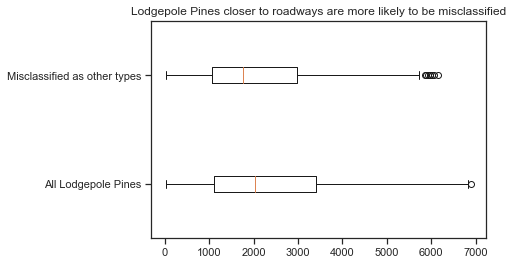

In [17]:
compare_roadway_dist = [df.Horizontal_Distance_To_Roadways[df.Cover_Type == 2],\
                     miss_data.Horizontal_Distance_To_Roadways[miss_data.Cover_Type == 2]]
fig_knn, ax_knn = plt.subplots()
ax_knn.set_title('Lodgepole Pines closer to roadways are more likely to be misclassified')
ax_knn.boxplot(compare_roadway_dist, vert=False, labels=("All Lodgepole Pines","Misclassified as other types"))
plt.show()

### 7.3 Random Forest

The driving motivation behind this model was obviously there is no better way to predict forest cover type other than using the trees themselves! The secondary motivation was their explanatory power, robustness, and possibility to ensemble them into evaluating complex decision boundaries. This model produced the second highest baseline accuracy amongst all the models of 88% on the dev data! We see that this model is facing the same problems as other models which is discerning between labels 1 and 2.

A unanimous decision was made to include this in the ensemble.

In [18]:
def RandomForest():

    skrf = RandomForestClassifier(class_weight = 'balanced', bootstrap = True, n_estimators = 900, 
                                  min_samples_leaf = 2, n_jobs = -2, random_state = 1337, criterion = "gini")

    skrf.fit(train_data,train_labels)

    skrf_pred = skrf.predict(dev_data)

    f1 = metrics.f1_score(dev_labels, skrf_pred, average = "weighted")

    print "Weighted F1 score for Random Forest =", f1
    
    print "\n==========================================\n"
    print "Confusion Matrix:"
    
    unique_label = np.unique(dev_labels)
    
    print(pd.DataFrame(confusion_matrix(dev_labels, skrf_pred, labels=unique_label), 
                   index=['true:{}'.format(x) for x in unique_label], 
                   columns=['pred:{}'.format(x) for x in unique_label]))
    
    print "\n==========================================\n"
    print "Classification Report:"
    print classification_report(dev_labels, skrf_pred)
    
    return skrf_pred
    
rf_pred = RandomForest()

Weighted F1 score for Random Forest = 0.8825938489193726


Confusion Matrix:
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       347        62         0         0         7         0        16
true:2.0        67       308         6         0        40         9         2
true:3.0         0         6       372        17         6        31         0
true:4.0         0         0         2       426         0         4         0
true:5.0         0        11         7         0       409         5         0
true:6.0         0         1        36         6         2       387         0
true:7.0         7         0         0         0         0         0       425


Classification Report:
              precision    recall  f1-score   support

         1.0       0.82      0.80      0.81       432
         2.0       0.79      0.71      0.75       432
         3.0       0.88      0.86      0.87       432
         4.0       0.95      0.99      0.97      

### 7.4 Decision Tree - ADABoost

Adaboost (short for adaptive boosting) uses boosting to turn weak learners into strong ones by forcing classifiers to learn and predict instances that are commonly misclassified. Boosting is particularly attractive for addressing this specific problem as we are aiming to generalize 15,000 train cases to predict over 560,000 test cases. For this reason, we need strong classifiers that have an easily tunable bias/variance tradeoff. In this way, decision trees are ideal to pair with adaboost as we are able to easily tune the variance parameter by adjusting the max_depth of each tree. Adaboost may introduce some level of bias, which is why tuning the number of estimators and the max_depth will be important in ensuring we capture the appropriate model parameters important for predictions without overfitting our models. Tree based classifiers are also faster to train, which makes this class of models particularly attractive.

After a iterating through EDA, feature engineering, and modeling, we were able to achieve an **accuracy of 89.0% on dev data**. It is important to note that we were able to achieve slightly higher accuracies on dev, but this increased the number of misclassified cover types 1 and 2. Being that our current models predict roughly 80% of the test data as either cover types 1 or 2, we found it important to maximize the separation between these two classes in our models. 

In [19]:
def ADABoost():

    dtree = DecisionTreeClassifier(criterion = 'entropy',  min_samples_leaf = 2, max_features = 0.7, 
                                   max_depth = 20)

    adaboost = AdaBoostClassifier(base_estimator = dtree, n_estimators = 800, 
                              learning_rate = .1, random_state = 1337)

    adaboost.fit(train_data,train_labels)

    ada_pred = adaboost.predict(dev_data)

    f1 = metrics.f1_score(dev_labels, ada_pred, average = "weighted")

    print "Weighted F1 score for ADAboost Classifier =", f1
    
    print "\n==========================================\n"
    print "Confusion Matrix:"
    
    unique_label = np.unique(dev_labels)
    
    print(pd.DataFrame(confusion_matrix(dev_labels, ada_pred, labels=unique_label), 
                   index=['true:{}'.format(x) for x in unique_label], 
                   columns=['pred:{}'.format(x) for x in unique_label]))
    
    print "\n==========================================\n"
    print "Classification Report:"
    print classification_report(dev_labels, ada_pred)
    
    features = adaboost.feature_importances_
    
    return ada_pred, features
    
ada_preds, ada_features = ADABoost()

Weighted F1 score for ADAboost Classifier = 0.8904119025512266


Confusion Matrix:
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       348        57         0         0         4         0        23
true:2.0        73       311         6         0        30        10         2
true:3.0         0         5       378        18         5        26         0
true:4.0         0         0         2       427         0         3         0
true:5.0         0         6         8         0       416         2         0
true:6.0         0         1        26         9         2       394         0
true:7.0         7         1         0         0         0         0       424


Classification Report:
              precision    recall  f1-score   support

         1.0       0.81      0.81      0.81       432
         2.0       0.82      0.72      0.77       432
         3.0       0.90      0.88      0.89       432
         4.0       0.94      0.99      0.96

#### 7.4.1 Feature Importance

To our surprise, many of the engineered features were selected as some of the most important pieces of information for these decision trees. Among the top were hydo_elevation, elevation, vertical distance to hydrology, hypotenuse water, and the addition of horizontal distance to fire point and hydrology.

In [20]:
feat_import(ada_features)

Top 20 Important Features

1. Vertical_Distance_To_Hydrology (0.178728)
2. elev_x_west (0.124007)
3. hydro_elev (0.106035)
4. Hillshade_Noon (0.080340)
5. fire_water_sub (0.076664)
6. water_road_sub (0.069458)
7. fire_water_sub_squared (0.066895)
8. Horizontal_Distance_To_Roadways (0.046738)
9. hyp_water (0.039826)
10. water_road_add (0.031751)
11. Elevation (0.029981)
12. fire_road_sub (0.021282)
13. squared_fire_dist (0.016754)
14. Soil_Type16 (0.013342)
15. fire_road_add (0.012942)
16. Soil_Type2 (0.011388)
17. Slope (0.011288)
18. fire_water_add (0.010185)
19. Hillshade_3pm (0.009623)
20. Soil_Type10 (0.008914)


### 7.5 Gradient Boosted Trees - XGBoost 

This model uses an ensemble method that sequentially adds predictors as it fits the residuals of the previous model to minimize loss. Given the original feature set with parameter optimization, we were able to get an 83% accuracy with our dev data. With the additional features and further optimization, we were able to achieve an accuracy of 89.1% with XGBoost on Dev data. With these results, we have included this model in our ensemble. 

In [21]:
def XGBoost():  
    # Generate the XGBoost model with optimized parameters
    xgboost = xgb.XGBClassifier(booster = 'gbtree', eta = 0.4, max_depth = 20,
                                gamma = 0.1, subsample = 0.8, colsample_bytree = 0.8, 
                                objective = 'binary:logistic', cv = 5, seed = 1337, oob_score = True)
        
    # Train our model and get our predicted output for dev data
    xgboost.fit(train_data, train_labels)
    xgboost_pred = xgboost.predict(dev_data)

    # Calculate and output the f1 score
    f1 = metrics.f1_score(dev_labels, xgboost_pred, average = "weighted")
    print "Weighted F1 score for XGBoost Classifier =", f1
    
    # Output the confusion matrix for our results
    print "==================== Confusion Matrix ======================"
    unique_label = np.unique(dev_labels)
    
    print(pd.DataFrame(confusion_matrix(dev_labels, xgboost_pred, labels=unique_label), 
                   index=['true:{}'.format(x) for x in unique_label], 
                   columns=['pred:{}'.format(x) for x in unique_label]))
    
    # Output the classification report for our results
    print "==================== Classification Report ======================"
    print classification_report(dev_labels, xgboost_pred)
    
    features = xgboost.feature_importances_
    
    return xgboost_pred, features

xgb_preds, xgb_features = XGBoost()

Weighted F1 score for XGBoost Classifier = 0.8912958178013973
==================== Confusion Matrix ======================
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       360        46         0         0         7         0        19
true:2.0        65       315         8         0        36         6         2
true:3.0         0         7       373        17         6        29         0
true:4.0         0         0         4       424         0         4         0
true:5.0         0         7         9         0       414         2         0
true:6.0         0         3        33         6         1       389         0
true:7.0         6         1         0         0         0         0       425
==================== Classification Report ======================
              precision    recall  f1-score   support

         1.0       0.84      0.83      0.83       432
         2.0       0.83      0.73      0.78       432
         3.0    

#### 7.5.1 Feature Importance

XGBoost has identified similar features as the most important features to build the models off of with the most important feature being elevation. 

In [22]:
feat_import(xgb_features)

Top 20 Important Features

1. Elevation (0.081201)
2. hydro_elev (0.078621)
3. fire_road_add (0.061774)
4. fire_road_sub (0.061385)
5. Hillshade_Noon (0.053801)
6. Hillshade_9am (0.051720)
7. elev_x_west (0.051294)
8. water_road_sub (0.050661)
9. Horizontal_Distance_To_Roadways (0.049261)
10. Vertical_Distance_To_Hydrology (0.048786)
11. Horizontal_Distance_To_Fire_Points (0.045682)
12. fire_water_add (0.043844)
13. Hillshade_3pm (0.043370)
14. water_road_add (0.042165)
15. fire_water_sub (0.039986)
16. hyp_water (0.035713)
17. Slope (0.035153)
18. Horizontal_Distance_To_Hydrology (0.033681)
19. fire_water_sub_squared (0.010906)
20. squared_fire_dist (0.009373)


### 7.6 ExtraTrees

When in doubt, add more trees!

What primarily differentiates extra trees from random forests is that when choosing variables at a split, samples are drawn from the entire training set instead of a bootstrap sample of the training set. Additionally, splits are chosen completely at random from the range of values in the sample at each split. 

At this stage we are really starting to see the limitations of the data. Even though this model produces the highest accuracy on the dev data (90.7%) it is still only a very small increment over the random forest model. What is encouraging is that the misclassification between labels 1 and 2 is slightly lower!

A unanimous decision was made to include this model in the ensemble.

In [23]:
def extra_tree_classifier(train, train_labs, dev, dev_labs):
   
    extra_trees = ExtraTreesClassifier(n_estimators = 6000, criterion = 'gini', max_depth = None, 
                                   max_features = 'auto', bootstrap = False, oob_score = False, 
                                   n_jobs = -1, random_state = 1337)

    extra_trees.fit(train, train_labs)

    extra_preds = extra_trees.predict(dev)

    f1 = metrics.f1_score(dev_labs, extra_preds, average = "weighted")

    print "Weighted F1 score for Extra Trees Classifier =", f1
    
    print "\n==========================================\n"
    print "Confusion Matrix:"
    
    unique_label = np.unique(dev_labs)
    
    print(pd.DataFrame(confusion_matrix(dev_labs, extra_preds, labels=unique_label), 
                   index=['true:{}'.format(x) for x in unique_label], 
                   columns=['pred:{}'.format(x) for x in unique_label]))
    
    print "\n==========================================\n"
    print "Classification Report:"
    print classification_report(dev_labs, extra_preds)
    
    feats = extra_trees.feature_importances_
    
    extra_data = dev[(extra_preds == 1) | (extra_preds == 2)]
    extra_labels = extra_preds[(extra_preds == 1) | (extra_preds == 2)]
    true_labels = dev_labs[(extra_preds == 1) | (extra_preds == 2)]
    #print feats
    
    return extra_preds, feats, extra_data, extra_labels, true_labels

extra_preds, features_extra, extra_data, extra_labels, true_labels = extra_tree_classifier(train = train_data, train_labs = train_labels, 
                                                    dev = dev_data, dev_labs = dev_labels)

Weighted F1 score for Extra Trees Classifier = 0.906549876954786


Confusion Matrix:
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       367        50         0         0         5         0        10
true:2.0        55       336         6         0        27         6         2
true:3.0         0         4       382        16         5        25         0
true:4.0         0         0         4       423         0         5         0
true:5.0         0         5         9         0       417         1         0
true:6.0         0         1        31         3         2       395         0
true:7.0         6         2         0         0         0         0       424


Classification Report:
              precision    recall  f1-score   support

         1.0       0.86      0.85      0.85       432
         2.0       0.84      0.78      0.81       432
         3.0       0.88      0.88      0.88       432
         4.0       0.96      0.98      0.

#### 7.6.1 Feature Importance

Although many of the important features are similar across the tree based classifiers, to our surprise, we found that wilderness_area4 was one of the most important features for ExtraTrees. Extra trees makes random split points based on the range of values for each feature. It is possible that, in doing so, wilderness area 4 has defining features that help predict differences between cover types 1 and 2. 

In [24]:
feat_import(features_extra, n = 20)

Top 20 Important Features

1. hydro_elev (0.103622)
2. Elevation (0.101729)
3. Wilderness_Area4 (0.048583)
4. fire_road_add (0.035748)
5. Horizontal_Distance_To_Roadways (0.035127)
6. water_road_sub (0.034822)
7. water_road_add (0.034036)
8. fire_road_sub (0.029225)
9. Soil_Type10 (0.028591)
10. hyp_water (0.028353)
11. Horizontal_Distance_To_Hydrology (0.028088)
12. fire_water_add (0.027623)
13. Hillshade_9am (0.026268)
14. Horizontal_Distance_To_Fire_Points (0.026075)
15. squared_fire_dist (0.025469)
16. fire_water_sub (0.024991)
17. elev_x_west (0.024438)
18. fire_water_sub_squared (0.024420)
19. Vertical_Distance_To_Hydrology (0.023741)
20. Hillshade_Noon (0.023194)


### 7.7 Tree Based Classifier Misclassification EDA

Now we would like to take some time to investigate the misclassified instances among the top tree based classifiers. When checking the distribution of the misclassified instances across all models, we find that there are a total of 184 cases that each of the models share. Of these, misclassifying 1's and 2's are the most problematic as it appears as though the test data are predominantly comprised of these instances. Roughly 80~85% of the predictions are either covertypes 1 or 2, and roughly 10% are comprised of 3's and 6's. We investigated a series of boxplots to look at the distribution and see if there were any features that we could use to improve the resolution between cover types 1 and 2. Based on this EDA, we identified the engineered feature horizontal_distance_fire_points minus horizontal_distance_to_hydrology as a candidate variable to square and include in our models. This feature improved dev and test accuracy. The key plot is presented below.

In [25]:
check_data_xg, labels_xg, preds_xg = misclass_drilldown(pred = xgb_preds)
check_data_extra, labels_extra, preds_extra = misclass_drilldown(pred = extra_preds)
check_data_ada, labels_ada, preds_ada = misclass_drilldown(pred = ada_preds)
check_data_rf, labels_rf, preds_rf = misclass_drilldown(pred = rf_pred)

In [26]:
diff_xg = set(check_data_xg.Id) - set(check_data_extra.Id) - set(check_data_ada.Id) - set(check_data_rf)
print 'Unique errors in XG relative to Extra Trees and ADABoost and Random Forest',len(diff_xg)

diff_extra = set(check_data_extra.Id) - set(check_data_xg.Id) - set(check_data_ada.Id) - set(check_data_rf)
print '\nUnique errors in Extra Trees relative to XGBoost and ADABoost and Random Forest',len(diff_extra)

diff_ada = set(check_data_ada.Id) - set(check_data_xg.Id) - set(check_data_extra.Id) - set(check_data_rf)
print '\nUnique errors in Ada relative to XGBoost and Extra Trees and Random Forest',len(diff_ada)

diff_rf = set(check_data_rf.Id)- set(check_data_ada.Id) - set(check_data_xg.Id) - set(check_data_extra.Id) 
print '\nUnique Errors in Random Forest relative to XGBoost and Extra Trees and Ada Boost',len(diff_rf)

same = set(check_data_xg.Id).intersection(set(check_data_extra.Id))\
    .intersection(set(check_data_ada.Id)).intersection(set(check_data_rf.Id))

print '\nNumber of same mistakes =',len(same)

Unique errors in XG relative to Extra Trees and ADABoost and Random Forest 40

Unique errors in Extra Trees relative to XGBoost and ADABoost and Random Forest 47

Unique errors in Ada relative to XGBoost and Extra Trees and Random Forest 43

Unique Errors in Random Forest relative to XGBoost and Extra Trees and Ada Boost 43

Number of same mistakes = 179


In [27]:
covers = check_data_extra.loc[check_data_extra['Id'].isin(same)]
most_errors = covers[(covers['Cover_Type'] == 1) | (covers['Cover_Type'] == 2) |\
                     (covers['Cover_Type'] == 3) | (covers['Cover_Type'] == 6)]

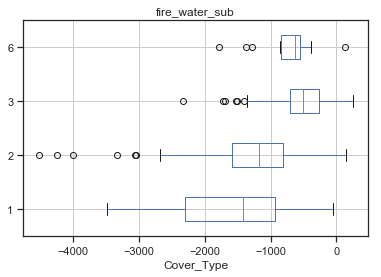

In [28]:
axes = most_errors.boxplot(vert=False,column=['fire_water_sub'],by="Cover_Type")
fig = axes.get_figure().suptitle('')

#### 7.7.1 3D Plot of Misclassified Instances

We created a 3D plot to see if there are what appear to be linearly separable lines among the commonly misclassified instances. There appears to be a separable hyperplane among the hard cases when comparing cover types 1 vs 2, and cover types 3 vs 6. It is hard to tell if this would improve accuracy as these data may heavily overlap other classes in the dataset. 

**Please note that the graph is interactive and you can filter out Cover Types by clicking on the legend.**

In [29]:
py.offline.init_notebook_mode(connected = True)

data = []
clusters = []
colorway = ['#f3cec9', '#e7a4b6', '#cd7eaf', '#a262a9', '#6f4d96', '#3d3b72', '#182844']

for i in range(len(np.unique(covers['Cover_Type'].values))):
    name = categories[i]
    color = colorway[i]
    X = covers[covers['Cover_Type'] == (i + 1)]['Slope']
    Y = covers[covers['Cover_Type'] == (i + 1)]['Elevation']
    Z = covers[covers['Cover_Type'] == (i + 1)]['fire_water_sub']
    
    trace = dict(
        name = name,
        x = X, y = Y, z = Z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, color=color, line=dict(width=0) ) )
    data.append( trace )

layout = dict(
    width=800,
    height=550,
    autosize=False,
    title='Slope by Elevation by Subtracted Horizontal Distance to Fire Points and Hydrology',
    scene=dict(
        xaxis=dict(
            title = 'Slope',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title = 'Elevation',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title = 'Fire Points Minus Hydrology',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data, layout=layout)

py.offline.iplot(fig, filename='simple-3d-scatter')

### 7.8 Gradient Boosting Classifier

Our attention was drawn to the Gradient Boosting Model (GBC) as a direct result of the performance of random forests. GBC also uses decision trees as it's underlying model.

What makes GBC appealing is that it is an additive model. So the trees are added as needed and gradient descent is used to minimize loss upon addition. Using a nominal amount of estimators we observed an overall accuracy of 86%. We are curious to see how this model will perform in an ensemble!

A unanimous decision was made to include this in the ensemble.

In [30]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.4, max_depth=25)
clf.fit(train_data, train_labels)
print clf.score(dev_data, dev_labels)

gb_preds = clf.predict(dev_data)

print "Confusion Matrix:"
    
unique_label = np.unique(dev_labels)
    
print(pd.DataFrame(confusion_matrix(dev_labels, gb_preds, labels=unique_label), 
                index=['true:{}'.format(x) for x in unique_label], 
                columns=['pred:{}'.format(x) for x in unique_label]))
    
print "\n==========================================\n"
print "Classification Report:"
print classification_report(dev_labels, gb_preds)

0.861441798941799
Confusion Matrix:
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       335        60         0         0         6         1        30
true:2.0        78       297        11         0        34         8         4
true:3.0         0         5       357        20         6        44         0
true:4.0         0         0         9       413         0        10         0
true:5.0         4        11        11         0       400         6         0
true:6.0         0         0        37         8         3       384         0
true:7.0        10         3         0         0         0         0       419


Classification Report:
              precision    recall  f1-score   support

         1.0       0.78      0.78      0.78       432
         2.0       0.79      0.69      0.74       432
         3.0       0.84      0.83      0.83       432
         4.0       0.94      0.96      0.95       432
         5.0       0.89      0.93   

### 7.9 Support Vector Machines

Based on EDA, there appears to be separable lines among classes despite the many features that are included in the data. Support vector machines (SVMs) may be a great classifier for separating these data, and may be particularly powerful when creating an ensemble of models because the misclassified instances in SVMs may be different from those in the tree based classifiers. Although SVMs take slightly longer to train on large datasets, they are easily tunable, which makes this model particularly attractive.

We were able to achieve an **accuracy of 86.4% on dev data**.

In [31]:
clf = svm.SVC(C = 5, gamma = 0.5, kernel = 'rbf')

clf.fit(scaled_train_data , train_labels)

svm_preds = clf.predict(scaled_dev_data)

f1 = metrics.f1_score(dev_labels, svm_preds, average = "weighted")

print "Weighted F1 score for SVM Classifier =", f1
    
print "\n==========================================\n"
print "Confusion Matrix:"
    
unique_label = np.unique(dev_labels)
    
print(pd.DataFrame(confusion_matrix(dev_labels, svm_preds, labels=unique_label), 
                    index=['true:{}'.format(x) for x in unique_label], 
                    columns=['pred:{}'.format(x) for x in unique_label]))
print "\n==========================================\n"
print "Classification Report:"
print classification_report(dev_labels, svm_preds)

Weighted F1 score for SVM Classifier = 0.863763606658794


Confusion Matrix:
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       349        73         0         0         3         0         7
true:2.0        79       306         8         0        31         7         1
true:3.0         4        12       351        16         5        44         0
true:4.0         0         1         6       405         0        20         0
true:5.0         4        11         8         0       405         4         0
true:6.0         1         4        44         3         2       378         0
true:7.0        11         2         0         0         0         0       419


Classification Report:
              precision    recall  f1-score   support

         1.0       0.78      0.81      0.79       432
         2.0       0.75      0.71      0.73       432
         3.0       0.84      0.81      0.83       432
         4.0       0.96      0.94      0.95      

#### 7.9.1 EDA for SVM Misclassifications

Based on our EDA of the misclassified instances, there are a few candidate polynomial features to investigate that may improve the accuracy of SVMs. Some of these features include Horizontal Distance to Hydrology, Elevation, and the engineered feature horizontal distance to fire point minus road (graphs shown below). Training SVMs on a separate dataset would likely improve the accuracy of this model. This should be further investigated in future work.

In [32]:
check_data_svm, labels_svm, preds_svm = misclass_drilldown(pred = svm_preds)

In [33]:
same_svms = set(check_data_svm.Id).intersection(set(covers.Id))
print 'The number of misclassified instances shared between SVM and Tree Based Classifiers =',len(same_svms)

unique_svms = set(check_data_svm.Id) - set(covers.Id)
print 'The number of unique SVM misclassifications compared to Tree Based Classifiers =',len(unique_svms)

The number of misclassified instances shared between SVM and Tree Based Classifiers = 150
The number of unique SVM misclassifications compared to Tree Based Classifiers = 261


In [34]:
covers_SVM = check_data_extra.loc[check_data_extra['Id'].isin(unique_svms)]
most_errors = covers_SVM[(covers_SVM['Cover_Type'] == 1) | (covers_SVM['Cover_Type'] == 2) |\
                         (covers_SVM['Cover_Type'] == 3) | (covers_SVM['Cover_Type'] == 6)]

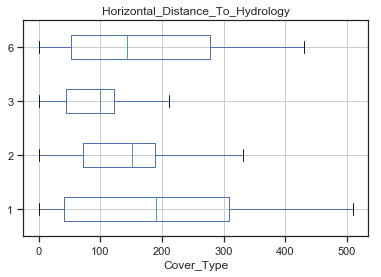

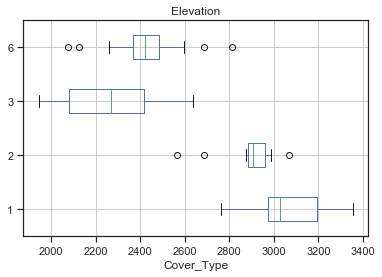

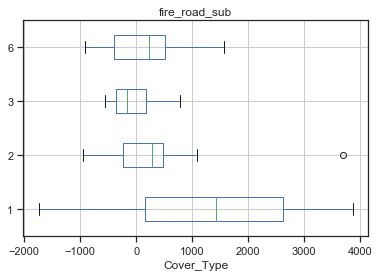

In [35]:
axes = most_errors.boxplot(vert=False,column=['Horizontal_Distance_To_Hydrology'],by="Cover_Type")
fig = axes.get_figure().suptitle('')

axes = most_errors.boxplot(vert=False,column=['Elevation'],by="Cover_Type")
fig = axes.get_figure().suptitle('')

axes = most_errors.boxplot(vert=False,column=['fire_road_sub'],by="Cover_Type")
fig = axes.get_figure().suptitle('')

### 7.10 PCA and GMM

With an accuracy of only 72%, our Gaussian Mixture Models were still included in the ensemble because they do improve our overall accuracy. The team expects that having one model per species may be inadequate to account for microclimates in the 4 far-flung wilderness areas. Please see the appendix for exploratory work done to build GMMs tailored to each park, which is already showing the capability to increase accuracy for certain species. Especially because Wyoming's parks will have their own microclimates, we would recommend this approach going forward.

In [36]:
def PCA_GMM():
    # If using this model, you can't use the engineered features wilderness category and soil properties. GMM works 
    # better with dummy variables.
    
    n = 40
    f = 50
    inits = 20
    
    PCA_model = PCA(n_components = n)
    PCA_Data = PCA_model.fit(train_data).transform(train_data)
    
    GMM_Model1 = GaussianMixture(n_components = f, covariance_type = 'full', n_init = inits, reg_covar = 0.001)
    GMM_Model1.fit(PCA_Data[train_labels == 1])
    
    GMM_Model2 = GaussianMixture(n_components = f, covariance_type = 'full', n_init = inits, reg_covar = 0.001)
    GMM_Model2.fit(PCA_Data[train_labels == 2])
    
    GMM_Model3 = GaussianMixture(n_components = f, covariance_type = 'full', n_init = inits, reg_covar = 0.001)
    GMM_Model3.fit(PCA_Data[train_labels == 3])
    
    GMM_Model4 = GaussianMixture(n_components = f, covariance_type = 'full', n_init = inits, reg_covar = 0.001)
    GMM_Model4.fit(PCA_Data[train_labels == 4])
    
    GMM_Model5 = GaussianMixture(n_components = f, covariance_type = 'full', n_init = inits, reg_covar = 0.001)
    GMM_Model5.fit(PCA_Data[train_labels == 5])
    
    GMM_Model6 = GaussianMixture(n_components = f, covariance_type = 'full', n_init = inits, reg_covar = 0.001)
    GMM_Model6.fit(PCA_Data[train_labels == 6])
    
    GMM_Model7 = GaussianMixture(n_components = f, covariance_type = 'full', n_init = inits, reg_covar = 0.001)
    GMM_Model7.fit(PCA_Data[train_labels == 7])
    
    PCA_Test_Data = PCA_model.transform(dev_data)
    
    score1 = GMM_Model1.score_samples(PCA_Test_Data)
    score2 = GMM_Model2.score_samples(PCA_Test_Data)
    score3 = GMM_Model3.score_samples(PCA_Test_Data)
    score4 = GMM_Model4.score_samples(PCA_Test_Data)
    score5 = GMM_Model5.score_samples(PCA_Test_Data)
    score6 = GMM_Model6.score_samples(PCA_Test_Data)
    score7 = GMM_Model7.score_samples(PCA_Test_Data)
    
    max_probs = np.zeros((dev_data.shape[0],7))
    
    max_probs[:,0] = score1
    max_probs[:,1] = score2
    max_probs[:,2] = score3
    max_probs[:,3] = score4
    max_probs[:,4] = score5
    max_probs[:,5] = score6
    max_probs[:,6] = score7
    
    #max_probs = np.concatenate((score1, score2, score3, score4, score5, score6, score7), axis = 1)
    #print max_probs
    
    pred = []
    
    for i in range(max_probs.shape[0]):
        
        m = int(np.argmax(max_probs[i]))
        pred.append(m + 1)
        
    wrong_prediction = (pred != dev_labels)
    wrong = float(np.sum(wrong_prediction))
    size = float(len(dev_labels))
    acr = (size - wrong)/size
    print 'Accuracy = ', acr
    
    unique_label = np.unique(dev_labels)
    
    print(pd.DataFrame(confusion_matrix(dev_labels, pred, labels=unique_label), 
                   index=['true:{}'.format(x) for x in unique_label], 
                   columns=['pred:{}'.format(x) for x in unique_label]))
    
    return pred
    
gmm_pred = PCA_GMM()

Accuracy =  0.720238095238
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       250       167         0         0         3         0        12
true:2.0        99       317         1         0         8         5         2
true:3.0         2        44       249         9        13       115         0
true:4.0         0         7        41       348         0        36         0
true:5.0        21        74         7         0       329         1         0
true:6.0         5        65        48         5         6       303         0
true:7.0        31        19         0         0         0         0       382


#### 7.10.1 Misclassification Analysis

In [37]:
miss_data,actuals,wrong_preds = misclass_drilldown(np.array(gmm_pred) + 0.)

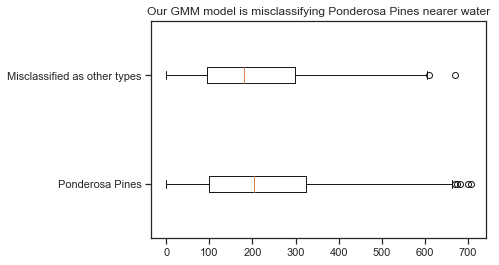

In [38]:
# Trees of type 3 (Ponderosa Pine)
compare_gmm_hyp_water = [df.hyp_water[df.Cover_Type == 3],\
                     miss_data.hyp_water[miss_data.Cover_Type == 3]]
fig_gmm, ax_gmm = plt.subplots()
ax_gmm.set_title('Our GMM model is misclassifying Ponderosa Pines nearer water')
ax_gmm.boxplot(compare_gmm_hyp_water,vert=False,labels=("Ponderosa Pines","Misclassified as other types"))
plt.show()

### 7.11 Ensemble Methods 

Ensembling models can be a powerful tool to help accentuate the strengths of each model and fill the gaps of other models. Based on the features we have created and the models we have developed, tree based classifiers seem to be performing the best with over 88% accuracy on dev data for all models. As seen before, many of the misclassified instances are similar among the tree based classifiers, so including different model types may help improve the accuracy of our predictions. 

We first investigate the strength of ensembling XGBoost, ExtraTrees, AdaBoost(decision trees), RandomForest, GradientBoosting, and SVMs using soft probabilities to predict the classes. The **accuracy on dev data came out to 90.1%**, which is not bad. Of note, the number of misclassifications between 1's and 2's decreased, which is important for translating this model to the test data. We seem to also do better on predicting 3's and 6's. 

Next, we investigate ensembling using hard voting and including predictions from deep learning, GMM, and kNN. Depending on which models were included, our accuracies on dev data fluctuated between **89.7% and 90.3%**. Although this may seem like an improvement, we see that the number of misclassifications among cover types 1 and 2 increase, which may ultimately decrease our accuracy on the test data. All in all, we see an improvement in the overall accuracy on dev data.

Lastly, we tried investigating ensemble of ensembles by funneling in the predictions from the soft prediction ensembles into the hard voting ensembles. We also added weight to classifiers with the highest predictions by giving them an additional vote in the hard voting classifier. This ultimately gave us the best accuracy on dev (**90.8%**) and the best accuracy on test data.

In [39]:
dtree = DecisionTreeClassifier(criterion = 'entropy',  min_samples_leaf = 2, max_features = 0.7, 
                                   max_depth = 20)

clf1 = xgb.XGBClassifier(booster = 'gbtree', eta = 0.4, max_depth = 20,
                                gamma = 0.1, subsample = 0.8, colsample_bytree = 0.8, 
                                objective = 'binary:logistic', cv = 5, seed = 1337, oob_score = True)

clf2 = ExtraTreesClassifier(n_estimators = 2500, criterion = 'gini', max_depth = None, 
                                   max_features = 'auto', bootstrap = False, oob_score = False, 
                                   n_jobs = -1, random_state = 1337)

clf3 = AdaBoostClassifier(base_estimator = dtree, n_estimators = 800, 
                              learning_rate = .1, random_state = 1337)

clf5 = RandomForestClassifier(class_weight = 'balanced', bootstrap = True, n_estimators = 900, 
                                  min_samples_leaf = 2, n_jobs = -2, random_state = 1337, criterion = "gini")

clf6 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.4, max_depth=25)

clf7 = svm.SVC(C = 5, gamma = 0.5, probability = True)

# init ensemble classifier
eclf = VotingClassifier(estimators=[('XGB', clf1), ('ET', clf2), ('Ada', clf3), 
                                    ('RF', clf5), ('GBC', clf6), ('SVM', clf7)] , 
                        voting='soft')

# fit on pre-processed data from the prev code cell
eclf = eclf.fit(train_data, train_labels)
# predict and print accuracy
eclf_pred = eclf.predict(dev_data)
accuracy = 100*round(accuracy_score(dev_labels, eclf_pred, normalize = True),3)
print accuracy

print "\n==========================================\n"
print "Confusion Matrix:"
    
unique_label = np.unique(dev_labels)
    
print(pd.DataFrame(confusion_matrix(dev_labels, eclf_pred, labels=unique_label), 
                index=['true:{}'.format(x) for x in unique_label], 
                columns=['pred:{}'.format(x) for x in unique_label]))
    
print "\n==========================================\n"
print "Classification Report:"
print classification_report(dev_labels, eclf_pred)

90.1


Confusion Matrix:
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       363        49         0         0         5         0        15
true:2.0        64       318         6         0        33         8         3
true:3.0         0         3       383        15         7        24         0
true:4.0         0         0         2       427         0         3         0
true:5.0         0         9         9         0       412         2         0
true:6.0         0         1        24         7         2       398         0
true:7.0         6         1         0         0         0         0       425


Classification Report:
              precision    recall  f1-score   support

         1.0       0.84      0.84      0.84       432
         2.0       0.83      0.74      0.78       432
         3.0       0.90      0.89      0.89       432
         4.0       0.95      0.99      0.97       432
         5.0       0.90      0.95      0.92    

#### 7.11.1 Ensembling Best Classifiers w/ kNN

As noted earlier, kNN had an accuracy of less than 35% on dev. Despite observing this issue, we wanted to test whether or not including kNN in our ensemble would help improve the accuracy by adding some bias towards other classifications in this hard voting method. To our surprise, we were able to improve accuracy slightly (relative to the dev accuracies of all models). Although ExtraTrees still achieved a higher accuracy on dev data, it is possible that using this ensemble on test data will achieve a similar (if not higher) accuracy.

***Models included: XGBoost, AdaBoost, DeepLearning, ExtraTrees, RandomForest, SVM, KNN***

In [40]:
ensemble = zip(xgb_preds, ada_preds, dl_preds, extra_preds, svm_preds, rf_pred, knn_preds)
ensemble_array = np.array(ensemble)

ensemble_modes = stats.mode(ensemble_array, axis = 1)
ensemble_preds_list = ensemble_modes[0].tolist()


ensemble_preds = [item for sublist in ensemble_preds_list for item in sublist]

wrong_prediction = (ensemble_preds != dev_labels)
wrong = float(np.sum(wrong_prediction))
size = float(len(dev_labels))
acr = (size - wrong)/size
print 'Accuracy = ', acr
    
unique_label = np.unique(dev_labels)
    
print(pd.DataFrame(confusion_matrix(dev_labels, ensemble_preds, labels=unique_label), 
                  index=['true:{}'.format(x) for x in unique_label], 
                  columns=['pred:{}'.format(x) for x in unique_label]))

Accuracy =  0.897156084656
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       361        53         0         0         3         0        15
true:2.0        66       321         8         0        29         6         2
true:3.0         0         5       377        17         4        29         0
true:4.0         0         0         2       427         0         3         0
true:5.0         0         6        10         0       414         2         0
true:6.0         0         1        35         6         2       388         0
true:7.0         6         1         0         0         0         0       425


#### 7.11.2 Ensembling Best Classifiers w/ GMM Predictions

Next, we wanted to see whether or not including GMM would help our overall prediction accuracy on Dev. Despite having a lower accuracy (72%) on dev, we find that the inclusion of GMM improves the overall accuracy of the ensemble to 90.1%; our best accuracy yet. Although the accuracy has improved, the misclassification rate of 1's and 2's is still relatively high compared to ExtraTrees. 

***Models included: XGBoost, AdaBoost, DeepLearning, ExtraTrees, RandomForest, SVM, GMM***

In [41]:
ensemble = zip(xgb_preds, ada_preds, dl_preds, extra_preds, svm_preds, rf_pred, gmm_pred)
ensemble_array = np.array(ensemble)

ensemble_modes = stats.mode(ensemble_array, axis = 1)
ensemble_preds_list = ensemble_modes[0].tolist()


ensemble_preds = [item for sublist in ensemble_preds_list for item in sublist]

wrong_prediction = (ensemble_preds != dev_labels)
wrong = float(np.sum(wrong_prediction))
size = float(len(dev_labels))
acr = (size - wrong)/size
print 'Accuracy = ', acr
    
unique_label = np.unique(dev_labels)
    
print(pd.DataFrame(confusion_matrix(dev_labels, ensemble_preds, labels=unique_label), 
                  index=['true:{}'.format(x) for x in unique_label], 
                  columns=['pred:{}'.format(x) for x in unique_label]))


Accuracy =  0.899470899471
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       358        56         0         0         3         0        15
true:2.0        57       333         6         0        27         7         2
true:3.0         0         5       374        17         4        32         0
true:4.0         0         0         2       427         0         3         0
true:5.0         0         8         9         0       414         1         0
true:6.0         0         1        34         6         2       389         0
true:7.0         6         1         0         0         0         0       425


#### 7.11.3 Ensemble of Strongest Classifiers Removing Deep Learning Predictions

Although deep learning may ultimately perform very well after tuning the parameters more, we decided to remove these predictions from the ensemble to see how accurate our predictions could be. We found that this series of ensembles provided the best accuracy on misclassifying 1's as 2's. 

***Models included: XGBoost, AdaBoost, ExtraTrees, RandomForest, SVM, GMM***

In [42]:
ensemble = zip(xgb_preds, ada_preds, extra_preds, rf_pred, svm_preds, gmm_pred)
ensemble_array = np.array(ensemble)

ensemble_modes = stats.mode(ensemble_array, axis = 1)
ensemble_preds_list = ensemble_modes[0].tolist()


ensemble_preds = [item for sublist in ensemble_preds_list for item in sublist]

wrong_prediction = (ensemble_preds != dev_labels)
wrong = float(np.sum(wrong_prediction))
size = float(len(dev_labels))
acr = (size - wrong)/size
print 'Accuracy = ', acr
    
unique_label = np.unique(dev_labels)
    
print(pd.DataFrame(confusion_matrix(dev_labels, ensemble_preds, labels=unique_label), 
                  index=['true:{}'.format(x) for x in unique_label], 
                  columns=['pred:{}'.format(x) for x in unique_label]))

Accuracy =  0.903108465608
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       377        42         0         0         3         0        10
true:2.0        64       327         6         0        26         7         2
true:3.0         0         6       377        16         4        29         0
true:4.0         0         0         4       425         0         3         0
true:5.0         0         8         9         0       414         1         0
true:6.0         0         2        36         6         2       386         0
true:7.0         6         1         0         0         0         0       425


#### 7.11.4 Ensemble of Ensembles

Lastly, we added weights to certain classifiers by giving them additional votes in the ensemble. To help improve the prediction accuracies, we also included the predictions from the soft voting ensemble into this series of ensembles. Although RandomForest gave great accuracy, XGBoost, Adaboost, and ExtraTrees gave better accuracies so we were concerned about introducing undue bias by adding votes to commonly misclassified instances. For this reason, we have removed random forest from this ensemble. This ensemble not only provided the best accuracy on dev data, but it also helped with the misclassifications between 1s and 2s.

***Models included: XGBoost (1 vote), AdaBoost (2 votes), ExtraTrees (3 votes), SoftProbEnsemble (2 votes), SVM (2 votes), GMM (2 votes)***

In [43]:
ensemble = zip(xgb_preds, ada_preds, ada_preds, extra_preds, extra_preds, extra_preds, 
                eclf_pred,  eclf_pred, svm_preds, svm_preds, gmm_pred, gmm_pred)
ensemble_array = np.array(ensemble)

ensemble_modes = stats.mode(ensemble_array, axis = 1)
ensemble_preds_list = ensemble_modes[0].tolist()


ensemble_preds = [item for sublist in ensemble_preds_list for item in sublist]

wrong_prediction = (ensemble_preds != dev_labels)
wrong = float(np.sum(wrong_prediction))
size = float(len(dev_labels))
acr = (size - wrong)/size
print 'Accuracy = ', acr
    
unique_label = np.unique(dev_labels)
    
print(pd.DataFrame(confusion_matrix(dev_labels, ensemble_preds, labels=unique_label), 
                  index=['true:{}'.format(x) for x in unique_label], 
                  columns=['pred:{}'.format(x) for x in unique_label]))

Accuracy =  0.908399470899
          pred:1.0  pred:2.0  pred:3.0  pred:4.0  pred:5.0  pred:6.0  pred:7.0
true:1.0       370        48         0         0         4         0        10
true:2.0        58       337         6         0        23         6         2
true:3.0         0         5       379        15         5        28         0
true:4.0         0         0         2       426         0         4         0
true:5.0         0         7         9         0       415         1         0
true:6.0         0         1        30         3         2       396         0
true:7.0         6         2         0         0         0         0       424


## 8. Summary of Results

We have summarized our dev and test accuracies for all models in a table below. Among individual models, ExtraTrees took the cake and won with the highest dev accuracy (**90.752%**) and subsequent test accuracy (**81.362%**). Utilizing an ensemble of ensembles, we were able to achieve the highest overall dev and test accuracy among all classifiers (**90.674%** and **82.175%**, respectively). Tree based classifiers achieved a dev accuracy of 85% or greater, and a test accuracy of 75% or greater. Gaussian mixture models achieved an accuracy of 72.024% on dev data, which translated to a 67.618% accuracy on test data. To our surprise, SVM and Deep Learning had poor performance on test data despite achieving relatively high dev accuracies. This is particularly interesting because of the inclusion of SVM in the ensemble of ensembles was necessary for achieving the highest accuracy. Please refer to the conclusion section for more discussion on this topic regarding approach, challenges and next steps.

|**Model**                    |**Dev Acc.** |**Test Acc.**|
|:---------------------------:|:-----------:|:-----------:|
|**Ensemble of Ensembles**    | **90.674%** | **82.175%** |
|**ExtraTrees**               | **90.752%** | **81.362%** |
|Ensembles w/ GMM             |   90.079%   |   81.207%   |
|Ensembles w/o DL             |   90.410%   |   81.106%   |
|Ensembles w/ KNN             |   89.716%   |   80.312%   |
|Ensemble SoftVote            |   89.900%   |   79.864%   |
|AdaBoost                     |   88.477%   |   79.055%   |
|XGBoost                      |   88.626%   |   78.859%   |
|RandomForest                 |   88.532%   |   77.350%   |
|GradientBoostingClassifier   |   85.185%   |   75.434%   |
|GMM                          |   72.024%   |   67.618%   |
|SVM                          |   86.376%   |   49.545%   |
|DeepLearning                 |   78.609%   |   36.430%   |
|KNN                          |   28.900%   |   23.142%   |

## 9. Conclusion

As you can see from the table above, each type of model has its strengths and weaknesses, and the team achieved our highest predictive power through an ensemble of a handful of models of different types.  With this ensemble approach, we can confirm that the information gathered by Colorado (entirely cartographic in nature, including universally-applicable observations of elevation, aspect, slope, shade, hydrology, fire, roadway and soil types) is a very satisfactory data source for machine learning. We fully expect that - given a training dataset of similar labeled observations from Wyoming wilderness areas - our team should be able to deliver predictions meeting the Forest Department's need for 80+% accuracy. In fact, it is certainly possible that the existing models (those already built from Colorado data) could perform reasonably well "as-is" to get a very preliminary inventory of Wyoming parks - at least for those "close" to these Colorado parks (with similar weather patterns, elevation ranges, and species present, etc.). The predictions will of course be much more reliable when trained on Wyoming data, and serve better the needs of your fire, land, environment and commercial stakeholders. Before beginning such an exercise, consideration should be given to collecting enough training data and also to the possibility that one or two tree species may be challenging to fully discern, as we saw in Colorado.

A significant challenge faced throughout the journey was that the training data set is significantly smaller than the test data set. For the frequent testing of our models, we stratified the training data further into training and development data sets with an even 80/20 split across all cover types. While this was able to help us frequently test our models and identify general challenges and patterns, the performance of results between the development and test data sets were different. Testing our models against the test data was time-consuming since we needed to generate and export the test results and upload it onto kaggle to get accuracy. We found that the discrepancy between dev results and test results were 40% for SVM and on average 10% for tree-based classifiers. Although we observed this phenomenon, including SVMs in the ensemble of ensembles still improved our accuracy. Including SVMs likely helped sway the vote for other tree-based classifiers that were likely getting the prediction correct.  

Diving deep into the feature space we see that Spruce/Fir (label 1) trees are very similar to Lodgepole Pine (label 2). During our exploratory data analysis, we observed that there were significant feature overlap and no discernible decision boundary or clustering, although our models were able to determine a boundary. What amplifies this problem is that the majority of the test data consists of just these two labels. The Ponderosa Pine (label 3) also shares a feature space with the Douglas/Fir (label 6). The misclassification of labels 3 and 6 were less pronounced but still significant. Yet another issue with classifying between pines and firs. This trouble with differentiating caused the second highest misclassification in our models.

As part of our model building, we found that tree-based classifiers were particularly good relative to other models at minimizing errors between these output pairs. As such, our overall approach included using various decision tree models and tuning them specifically to minimize the errors between these two pairs of outputs. With these tuned models, we used ensembling techniques to combine their performance to produce a much better accuracy overall at correctly classifying these outputs. 


### Next Steps & Recommendations for the Wyoming Forest Department

Wyoming's Forest Department is keen to have a model that can predict forest coverage for Wyoming wilderness areas. Now that the DreamMachine team has shown success with our models on Colorado data, we feel certain that a model with similar predictive power can be developed for Wyoming. These would be our recommendations going forward:

 * We would like to review any existing survey/inventory data for Wyoming park tree species. If there are species we've not encountered previously in Colorado, we will need to adjust our models accordingly. 
 * As mentioned in the Gaussian Mixture Models section above, we would highly recommend investing in per-park models that are specific to Wyoming's own areas. Obviously the work done to build park-specific models for Colorado's wilderness areas should not be expected to translate well to Wyoming parks due to different microclimates among other factors, but the methods used in developing such models for Colorado can be implemented for Wyoming as well (once we have Wyoming data).
 * Finally, we would like to recommend a novel approach to collecting any data that the Wyoming Forest Department does not yet have: collecting forest survey data with DreamMachine drones, and labeling Wyoming park plots using new technology we have in development to perform tree species recognition using AI. This approach should prove much more cost-effective than sending personnel to scour thousands of square miles of land, and would be feasible for repeating every 5-10 years to keep the Forest Department fully informed regarding the health of your forests.

## Primary References

https://www.kaggle.com/c/forest-cover-type-prediction

Using cartographic variables only, predict the forest canopy cover type. This is a multi class problem where you get to try different algorithms and approaches.

### Additional References

https://www.firescience.gov/projects/03-1-1-06/project/03-1-1-06_03-1-1-06_mike_ryan_lodgepole_pine_ecology_lp_meeting_granby_sept_2007.pdf - Presentation by the Rocky Mountain Forest Services that tells the story and lifecycle of lodgepole pines

https://gisgeography.com/slope-aspect-microclimate-south-facing/ - provided clear illustrations for the team to learn to interpret the aspect dimension

http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-hillshade-works.htm - helped the team with these measures of sunlight exposure at various times of the day

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ - Reference content that helped guide our tuning of XGBoost

The team would also like to thank Google Earth for the ability to virtually visit the wilderness areas of interest.

# Appendix

### Exploration of developing park-specific models

This section is referenced in our exploration of building GMM models. We would recommend using such analysis and code to build park-specific GMM models for Wyoming wilderness areas.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

X_l2sep_WA1 = lda.fit(measure_transform(train_data[(train_data[:,25] == 1)],StandardScaler), train_labels[(train_data[:,25] == 1)])
WA1_score = X_l2sep_WA1.score(measure_transform(dev_data[(dev_data[:,25] == 1)],StandardScaler),dev_labels[(dev_data[:,25] ==1)])
print("LDA score for Spruce vs Lodgepole in WA1 {:.2%}".format(WA1_score))

X_l2sep_WA2 = lda.fit(measure_transform(train_data[(train_data[:,26] == 1)],StandardScaler), train_labels[(train_data[:,26] == 1)])
WA2_score = X_l2sep_WA2.score(measure_transform(dev_data[(dev_data[:,26] == 1)],StandardScaler),dev_labels[(dev_data[:,26] ==1)])
print("LDA score for Spruce vs Lodgepole in WA2 {:.2%}".format(WA2_score))

X_l2sep_WA3 = lda.fit(measure_transform(train_data[(train_data[:,27] == 1)],StandardScaler), train_labels[(train_data[:,27] == 1)])
WA3_score = X_l2sep_WA3.score(measure_transform(dev_data[(dev_data[:,27] == 1)],StandardScaler),dev_labels[(dev_data[:,27] ==1)])
print("LDA score for Spruce vs Lodgepole in WA3 {:.2%}".format(WA3_score))

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
WA1_disty = X_l2sep_WA1.transform(measure_transform(train_data[(train_data[:,25] == 1)],StandardScaler))
plt.hist(WA1_disty[train_labels[(train_data[:,25] == 1)]==1],alpha=0.5)
plt.hist(WA1_disty[train_labels[(train_data[:,25] == 1)]==2],alpha=0.5)
plt.title('Wilderness Area 1')

plt.subplot(1, 3, 2)
WA2_disty = X_l2sep_WA2.transform(measure_transform(train_data[(train_data[:,26] == 1)],StandardScaler))
plt.hist(WA2_disty[train_labels[(train_data[:,26] == 1)]==1],alpha=0.5)
plt.hist(WA2_disty[train_labels[(train_data[:,26] == 1)]==2],alpha=0.5)
plt.title('Wilderness Area 2')

plt.subplot(1, 3, 3)
WA3_disty = X_l2sep_WA3.transform(measure_transform(train_data[(train_data[:,27] == 1)],StandardScaler))
plt.hist(WA3_disty[train_labels[(train_data[:,27] == 1)]==1],alpha=0.5)
plt.hist(WA3_disty[train_labels[(train_data[:,27] == 1)]==2],alpha=0.5)
plt.title('Wilderness Area 3')
plt.show()

In [ ]:
# Create a dictionary to track park-specific training & dev subsets, labels, transforms and classifiers 
parks = {}
base = 'Wilderness_Area'
for i in range(1,5):
    parks[i]={}
    parks[i]['train_data'] = train_data[train_data[base+str(i)]==1]
    parks[i]['train_labels'] = train_labels[train_data[base+str(i)]==1]
    parks[i]['dev_data'] = dev_data[dev_data[base+str(i)]==1]
    parks[i]['dev_labels'] = dev_labels[dev_data[base+str(i)]==1]

In [ ]:
# Group columns by type of preprocessing needed

##################################################################################
# Please note that the ColumnTransformer function is new in scikit-learn v0.20.1
# BELOW WON'T WORK with older scikit-learn versions
##################################################################################


float_features = ['Elevation','Slope','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',\
               'Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points',\
               'water_access','hyp_water','hydro_elev','hydro_above','hydro_Hori_L_120',\
               'South=1&North=0','West=1&East=0','avg_sunlight',\
               'slope_x_west','slope_x_south',\
                'Elevation_G_3100','elev_x_west', 'elev_x_south',\
                 'north_x_elev_x_slope',\
                'fire_dist_adjust','fire_water_sub','fire_water_add',\
                  'fire_road_sub','fire_road_add',
                  'water_road_sub','water_road_add'
                 ] # comment out a line to skip that line's features in any model 

binary_features = [
                'Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4',\
                'Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8',\
                'Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12',\
                'Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16',\
                'Soil_Type17','Soil_Type18','Soil_Type19','Soil_Type20',\
                'Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24',\
                'Soil_Type25','Soil_Type26','Soil_Type27','Soil_Type28',\
                'Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32',\
                'Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type36',\
                'Soil_Type37','Soil_Type38','Soil_Type39','Soil_Type40',\
                'To_Fire_Or_Not_To_Fire','Elevation_Fire',\
                'Hillshade_10am','Hillshade_11am','Hillshade_1pm','Hillshade_2pm'
#                 'Wilderness_Area1','Wilderness_Area2',\
#                 'Wilderness_Area3','Wilderness_Area4'\
                ] # Shutting off wilderness areas because this notebook is for predictions given a park


float_transformer = Pipeline(steps=[
    ('float_scaler', StandardScaler()),
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('real_nums', float_transformer, float_features),
        ('skip_binaries', 'passthrough', binary_features)])

In [ ]:
for i in range(1,5):
    if parks[i]['train_data'].shape[0] == 0:
        continue
    else:
        parks[i]['train_data'] = preprocessor.fit_transform(parks[i]['train_data'])
        parks[i]['dev_data'] = preprocessor.transform(parks[i]['dev_data'])

In [ ]:
def hardcase_handling(park=1,pos=1,neg=2,num_pca=1,gmm_count=1,type_cov='diag'):
    """Provide a park and two tree types; this tunes an estimator using GMMs to pick most likely type"""
    
    class Twice_the_Classifier(BaseEstimator,ClassifierMixin,TransformerMixin):
        """Custom estimator """
        def __init__(self,num_pca=num_pca, gmm_count=gmm_count,type_cov=type_cov):
            self.num_pca = num_pca
            self.gmm_count = gmm_count
            self.type_cov = type_cov
            self.pca = None
            self.pc_X = None
            self.pca_transformed = None
            self.pos_classifier = None
            self.neg_classifier = None
            self.fitted = None

        def fit(self,X,y=None):
            self.pca_ = PCA(n_components=self.num_pca)
            self.pc_X_ = self.pca_.fit(X).transform(X)
            self.pos_classifier_ = GaussianMixture(n_components=self.gmm_count, covariance_type=self.type_cov)
            self.pos_classifier_.fit(self.pc_X_[y == pos])
            self.neg_classifier_ = GaussianMixture(n_components=self.gmm_count, covariance_type=self.type_cov)
            self.neg_classifier_.fit(self.pc_X_[y == neg])
            return self
        
        def transform(self,X):
            self.pca_transformed_ = self.pca_.transform(X)
            return self.pca_transformed_

        def predict(self,X): 
            ypred = (self.pos_classifier_.score_samples(self.pca_transformed_) > \
                            self.neg_classifier_.score_samples(self.pca_transformed_))
            ypred = np.where(ypred == 1, pos, neg)
            self.fitted_ = ypred
            return self.fitted_
        
        def score(self,X,y=None):
            got_right = np.sum(self.predict(self.transform(X)) == y)
            accuracy = np.divide(got_right,len(y),dtype=float)
            return accuracy
    
    subset_pos_data = parks[park]['train_data'][parks[park]['train_labels'] == pos]
    print("pos data",subset_pos_data.shape)
    subset_neg_data = parks[park]['train_data'][parks[park]['train_labels'] == neg]
    print("neg data",subset_neg_data.shape)
    X = np.concatenate((subset_pos_data,subset_neg_data),axis=0)
    
    subset_pos_labels = parks[park]['train_labels'][parks[park]['train_labels'] == pos]
    subset_neg_labels = parks[park]['train_labels'][parks[park]['train_labels'] == neg]
    y = np.concatenate((subset_pos_labels,subset_neg_labels),axis=0)
    print(X.shape,y.shape)
    
    print("Running a search; this will take a moment with cross-validation...")
    
    twice_as_nice = Twice_the_Classifier(num_pca,gmm_count,type_cov)
    param_grid = {'num_pca': num_pca,\
                'gmm_count': gmm_count,
                'type_cov': type_cov}
    searcher = GridSearchCV(twice_as_nice, param_grid,verbose=0,cv=3)
    searcher.fit(X=X, y=y)

    param_num = 0
    if searcher.best_params_['type_cov'] == 'spherical':
        param_num = (1 + searcher.best_params_['num_pca']) * searcher.best_params_['gmm_count'] * 2
    elif searcher.best_params_['type_cov'] == 'diag':
        param_num = (2* searcher.best_params_['num_pca']) * searcher.best_params_['gmm_count'] * 2
    elif searcher.best_params_['type_cov'] == 'tied':
        param_num = (2* searcher.best_params_['num_pca'] + 1) * searcher.best_params_['gmm_count'] * 2
    else:
        param_num = 0.5*(searcher.best_params_['num_pca']**2 - \
                         searcher.best_params_['num_pca']) * searcher.best_params_['gmm_count'] * 2
    print("Park = {}".format(park))
    print("Best parameters in this trial: ",searcher.best_params_)
    print("Accuracy with these parameters: {:0.2%}".format(searcher.best_score_))
    print("Total parameter count for this trial: {:.0f}".format(param_num))
    return (searcher.best_score_,searcher.best_params_,param_num)


pca_dims = (25,30)
gmm_counts = (3,5)
cov_types = ['spherical','diag','tied']
hardcase_handling(park=1,pos=1,neg=2,num_pca=pca_dims,gmm_count=gmm_counts,type_cov=cov_types)
# Above call says go to park 1 and differentiate tree types 1 and 2
# Another example would be hardcase_handling(park=3,pos=3,neg=6...)